## BOX OFFICE PREDICTION MODEL TRAINING SET

Data requirements:
- released between 2015 to Jan 2024 (later remove older titles)
- at least 60 days of wiki view
- at least 10 edits

filter out:
- bottom 5% of edits (10), bottom 5% of views (30k)
- bottom .5% of grosses, and top .5% of grosses
- NR and G rated films
- Special Events/Concerts/etc. genres


Model Parameters:
- Views
- Edits/Editors
- Num Locations
- Title Metadata
    - Genre
    - Rating
- COVID Flag


In [1]:
import pandas as pd
import re
import sys
import datetime as dt
import numpy as np
from scipy import stats
import holidays, dateutil.easter

import matplotlib.pyplot as plot

In [2]:
import requests
import json
from fake_useragent import UserAgent
from unidecode import unidecode

### set prediction week

In [4]:
## weekstart is Friday
def get_prediction_week(relative_weeks=None):

    if relative_weeks:
        date_str = (dt.date.today() - dt.timedelta(weeks=relative_weeks)).strftime('%Y-%m-%d')
        
    else:
        date_str = dt.date.today().strftime('%Y-%m-%d')
            
    fri_delta = 4 - pd.to_datetime(date_str).weekday()
        
    date_str = (pd.to_datetime(date_str) + dt.timedelta(days=fri_delta)).strftime('%Y-%m-%d')
    file_str = pd.to_datetime(date_str).strftime('%Y_%m_%d')
    
    return date_str, file_str

In [5]:
prediction_week, file_str = get_prediction_week()
print(prediction_week)

2025-05-09


### set upcoming date window

In [6]:
## get date cutoff for upcoming films, default to today
def relative_date_str(relative_weeks=None):

    if relative_weeks:
        date_str = (dt.date.today() - dt.timedelta(weeks=relative_weeks)).strftime('%Y-%m-%d')
        
    else:
        date_str = dt.date.today().strftime('%Y-%m-%d')
    
    return date_str


In [7]:
# date_cutoff = relative_date_str(relative_weeks=1)

date_cutoff = '2025-02-28'
print(date_cutoff)

2025-02-28


### pull wiki titles from gsheet 

In [10]:
wiki_titles = pd.read_excel('wiki_film_releases.xlsx')

print(wiki_titles.shape)
wiki_titles.head(3)

(1471, 8)


,title,title_id,release_date,distributor,wikipedia_url,budget,opening_locs,franchise
0,Weapons,1471,2025-08-08,WB,https://en.wikipedia.org/wiki/Weapons_(2025_film),NaN,NaN,NaN
1,"Bad Guys 2, The",1470,2025-08-01,UNI,https://en.wikipedia.org/wiki/The_Bad_Guys_2,NaN,NaN,NaN
2,How to Train Your Dragon,1469,2025-06-13,UNI,https://en.wikipedia.org/wiki/How_to_Train_You...,NaN,NaN,NaN


In [11]:
wiki_titles = wiki_titles[['title','distributor','wikipedia_url','title_id',
                           'release_date','franchise']]

wiki_titles['release_date'] = pd.to_datetime(wiki_titles['release_date'])

wiki_titles.rename(columns={'wikipedia_url':'wiki_url'}, inplace=True)

## ignore titles w/o wiki url
wiki_titles.dropna(subset=['wiki_url'], inplace=True)
wiki_titles = wiki_titles[wiki_titles['wiki_url'] != '']

print(wiki_titles.shape)
print(wiki_titles['title'].nunique())
wiki_titles.head()

(1452, 6)
1414


,title,distributor,wiki_url,title_id,release_date,franchise
0,Weapons,WB,https://en.wikipedia.org/wiki/Weapons_(2025_film),1471,2025-08-08,NaN
1,"Bad Guys 2, The",UNI,https://en.wikipedia.org/wiki/The_Bad_Guys_2,1470,2025-08-01,NaN
2,How to Train Your Dragon,UNI,https://en.wikipedia.org/wiki/How_to_Train_You...,1469,2025-06-13,NaN
3,Bring Her Back,A24,https://en.wikipedia.org/wiki/Bring_Her_Back,1468,2025-05-30,NaN
4,Lilo & Stitch,DIS,https://en.wikipedia.org/wiki/Lilo_%26_Stitch_...,1467,2025-05-23,NaN


In [12]:
wiki_df = wiki_titles.copy()

In [13]:
wiki_df['title'].nunique()

1414

In [14]:
wiki_df[wiki_df['title'].isna()]

,title,distributor,wiki_url,title_id,release_date,franchise


In [15]:
### filter to titles released prior to cutoff date

wiki_df = wiki_df[wiki_df['release_date'] <= date_cutoff]
wiki_df = wiki_df[wiki_df['release_date'] > '2015-07-01']

print(wiki_df.shape)
print(wiki_df.title.nunique())

(1356, 6)
1318


### get page name of wiki url

In [16]:
from urllib.parse import unquote, quote

In [17]:
## extract wiki page name (without url)
# wiki_df['wiki_url'] = wiki_df['wiki_url'].apply(lambda x: unquote(x))
wiki_df['wiki_page'] = wiki_df['wiki_url'].apply(lambda x: pd.Series(x).str.extract(r'(?<=wiki/)(.*)')[0].item())

In [18]:
wiki_df.head(3)

,title,distributor,wiki_url,title_id,release_date,franchise,wiki_page
39,Riff Raff,RSA,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,1432,2025-02-28,0.0,Riff_Raff_(2024_film)
40,Superboys of Malegaon,AMZMGM,https://en.wikipedia.org/wiki/Superboys_of_Mal...,1431,2025-02-28,NaN,Superboys_of_Malegaon
41,Last Breath,FOC,https://en.wikipedia.org/wiki/Last_Breath_(202...,1430,2025-02-28,0.0,Last_Breath_(2025_film)


In [205]:
wiki_df_plus = wiki_df[['title', 'title_id','wiki_url','release_date','wiki_page']].drop_duplicates()

In [206]:
## ignore these
wiki_df_plus = wiki_df_plus[~wiki_df_plus['title'].isin(['Little Women','Self/Less','Escape Room 2'])] 

In [207]:
print(wiki_df_plus.shape)

(1354, 5)


### find all redirected pages based on wiki df

In [209]:
def pull_redirected_pages(wiki_page_list):
    
    redirected_pages = pd.DataFrame()
    
    for p in wiki_page_list:
        
        url = f"https://en.wikipedia.org/w/api.php?action=query&titles={p}&prop=redirects&format=json"

        response = requests.get(url).content
        tmp_pages = json.loads(response)
        
        if 'query' in tmp_pages:
            
            page_dict = tmp_pages['query']['pages']

            page_ids = page_dict.keys()
            
            ## get page redirects
            for ids in page_ids:
                
                try:
                    tmp_pages = pd.DataFrame(page_dict[f'{ids}']['redirects'])[['title']]
                    tmp_pages.rename(columns={'title':'redirected_wiki_page'}, inplace=True)
                    tmp_pages['wiki_page'] = p
                    
                except:
                    tmp_pages = pd.DataFrame()
            
                redirected_pages = pd.concat([redirected_pages, tmp_pages])
    
    return redirected_pages



def clean_redirected_pages(redirected_pages_df):
    
    ### ignore 'disambiguation', 'draft', and wiki_pages with '&'
    wiki_redirected_clean = redirected_pages_df[~redirected_pages_df['redirected_wiki_page'].str.contains(r'disambiguation|^Draft[:]|^User[:]')]
    wiki_redirected_clean = wiki_redirected_clean[~wiki_redirected_clean['redirected_wiki_page'].str.contains(r'^List of')]
#     wiki_redirected_clean = wiki_redirected_clean[~wiki_redirected_clean['wiki_page'].str.contains('&')]
    
    wiki_redirected_clean['redirected_wiki_page'] = wiki_redirected_clean['redirected_wiki_page'].apply(lambda x: '_'.join(x.split()))
    wiki_redirected_clean.drop_duplicates(inplace=True)
    
    return wiki_redirected_clean
    
    
    
def pull_and_process_redirected_pages(wiki_df_plus):
    
    print('pull unique wiki page names')
    wiki_pages_list = wiki_df_plus['wiki_page'].unique().tolist()
    print(len(wiki_pages_list))
    
    wiki_redirected = pull_redirected_pages(wiki_pages_list)
    print(wiki_redirected.shape)
    
    print('drop unnecessary pages...')
    wiki_redirected_clean = clean_redirected_pages(wiki_redirected)
    print(wiki_redirected_clean.shape)
    
    print('unique wiki pages found with redirected pages: ')
    print(wiki_redirected_clean['wiki_page'].nunique())
    
    ## add title from wiki df
    wiki_redirected_clean = pd.merge(wiki_redirected_clean, 
                                     wiki_df_plus[['title','title_id','wiki_page','release_date']].drop_duplicates(),
                                     on='wiki_page')


    ## drop wiki_page, and rename redirected_wiki_page to use instead
    wiki_redirected_clean.drop(['wiki_page'], axis=1, inplace=True)
    wiki_redirected_clean.rename(columns={'redirected_wiki_page':'wiki_page'}, inplace=True)

    return wiki_redirected_clean


In [210]:
wiki_redirected_pages = pull_and_process_redirected_pages(wiki_df_plus)

pull unique wiki page names
1353
(4009, 2)
drop unnecessary pages...
(3248, 2)
unique wiki pages found with redirected pages: 
909


In [211]:
print(wiki_redirected_pages.shape)
wiki_redirected_pages.head()

(3249, 4)


,wiki_page,title,title_id,release_date
0,Riff_Raff_(upcoming_film),Riff Raff,1432,2025-02-28
1,Last_Breath_(upcoming_film),Last Breath,1430,2025-02-28
2,Unbreakable_Boy,"Unbreakable Boy, The",1429,2025-02-21
3,Captain_America_4,Captain America: Brave New World,1426,2025-02-14
4,Captain_America_New_World_Order,Captain America: Brave New World,1426,2025-02-14


In [213]:
## append titles that have redirected pages, so additional wiki page is used for wiki api call
wiki_df_plus = pd.concat([wiki_df_plus, wiki_redirected_pages], ignore_index=True).drop_duplicates()

## format out the special characters...
wiki_df_plus['wiki_page'] = wiki_df_plus['wiki_page'].apply(lambda x:  re.sub('[?]','%3F',x))
wiki_df_plus['wiki_page'] = wiki_df_plus['wiki_page'].apply(lambda x:  re.sub("[\']|[\’]",'%27',x))
wiki_df_plus['wiki_page'] = wiki_df_plus['wiki_page'].apply(lambda x:  re.sub("[&]",'%26',x))
wiki_df_plus['wiki_page'] = wiki_df_plus['wiki_page'].apply(lambda x:  re.sub("[-]|[–]|[–]",'%E2%80%93',x))
wiki_df_plus['wiki_page'] = wiki_df_plus['wiki_page'].apply(lambda x:  re.sub("é",'%C3%A9',x))
wiki_df_plus['wiki_page'] = wiki_df_plus['wiki_page'].apply(lambda x:  re.sub("à",'%C3%A0',x))
wiki_df_plus['wiki_page'] = wiki_df_plus['wiki_page'].apply(lambda x:  re.sub("ì",'%C3%AC',x))
wiki_df_plus['wiki_page'] = wiki_df_plus['wiki_page'].apply(lambda x:  re.sub("á",'%C3%A1',x))

wiki_df_plus = wiki_df_plus[~wiki_df_plus[['title','wiki_page']].duplicated(keep='first')]

print(wiki_df_plus.shape)
print(wiki_df_plus.wiki_page.nunique())
wiki_df_plus.head()

(4558, 5)
4556


,title,title_id,wiki_url,release_date,wiki_page
0,Riff Raff,1432,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,2025-02-28,Riff_Raff_(2024_film)
1,Superboys of Malegaon,1431,https://en.wikipedia.org/wiki/Superboys_of_Mal...,2025-02-28,Superboys_of_Malegaon
2,Last Breath,1430,https://en.wikipedia.org/wiki/Last_Breath_(202...,2025-02-28,Last_Breath_(2025_film)
3,"Unbreakable Boy, The",1429,https://en.wikipedia.org/wiki/The_Unbreakable_Boy,2025-02-21,The_Unbreakable_Boy
4,"Monkey, The",1428,https://en.wikipedia.org/wiki/The_Monkey_(film),2025-02-21,The_Monkey_(film)


In [ ]:
## ignore duped wiki_pages completely...
wiki_df_plus = wiki_df_plus[~wiki_df_plus[['wiki_page']].duplicated()]

### pull wiki views

In [242]:
def create_dataframe(parsed_data):
    return pd.DataFrame.from_dict(parsed_data, orient='index')


def expand_dictionary_to_dataframe(nested_dict):
    ## loop through nested dictionary and append to dataframe

    new_df = pd.DataFrame()

    for d in nested_dict:
        new_df = pd.concat([new_df, create_dataframe(nested_dict[d])], ignore_index=True)

    return new_df

In [243]:
def get_page_wiki_views(df,days_prior=None,date_start=None,date_end=None):
    
    ua = UserAgent()
    user_agent = ua.random
    
    wiki_views = pd.DataFrame()

    ## get wiki page
    wiki_page = df['wiki_page'].unique().tolist()
    
    for p in wiki_page:
        print(p)
        tmp = df[df['wiki_page'] == p][['title', 'wiki_page','release_date']].drop_duplicates()
        
        ## get date ranges for -180 from release_date
        if date_start is None:
            d1 = tmp['release_date'].iloc[0] + pd.Timedelta(days=days_prior)
            d1 = d1.strftime('%Y%m%d')
        else:
            d1 = date_start
            
        if date_end is None:
            d2 = tmp['release_date'].iloc[0] + pd.Timedelta(days=90+1)
            d2 = d2.strftime('%Y%m%d')
        else:
            d2 = date_end
            
        print(d1 + ' - ' + d2)
    
        tmp_views = requests.get('https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article'+
                                 '/en.wikipedia/all-access/user/{p}/daily/{d1}/{d2}'.format(p=p,d1=d1,d2=d2),
                                 headers ={'User-Agent':user_agent})
        try:
            tmp_views = pd.DataFrame(json.loads(tmp_views.content)['items']) 
            tmp_views['wiki_date'] = pd.to_datetime(tmp_views['timestamp'].apply(lambda x: dt.datetime.strptime(x, '%Y%m%d%H').date()))
            tmp_views['wiki_page'] = p
            
        except:
            tmp_views = pd.DataFrame()
            
        wiki_views = pd.concat([wiki_views, tmp_views])
        
    return wiki_views

In [216]:
print(wiki_df.title.nunique())
print(wiki_df_plus.title.nunique()) ## titles manually dropped out

1318
1316


### running all titles

In [257]:
today_str = re.sub('-','',str(dt.date.today()))

## re run all pages..want more days prior to release and more days after release incase of changing release dates
## add a little buffer for 180
wiki_re = get_page_wiki_views(df=wiki_df_plus,days_prior=-200) #360

Riff_Raff_(2024_film)
20240812 - 20250530
Superboys_of_Malegaon
20240812 - 20250530
Last_Breath_(2025_film)
20240812 - 20250530
The_Unbreakable_Boy
20240805 - 20250523
The_Monkey_(film)
20240805 - 20250523
Captain_America:_Brave_New_World
20240729 - 20250516
Paddington_in_Peru
20240729 - 20250516
Parthenope_(film)
20240722 - 20250509
Heart_Eyes
20240722 - 20250509
Love_Hurts_(2025_film)
20240722 - 20250509
Companion_(film)
20240715 - 20250502
Dog_Man_(film)
20240715 - 20250502
Love_Me_(2024_American_film)
20240715 - 20250502
Presence_(2024_film)
20240708 - 20250425
Flight_Risk_(film)
20240708 - 20250425
I%27m_Still_Here_(2024_film)
20240701 - 20250418
One_of_Them_Days
20240701 - 20250418
Wolf_Man_(2025_film)
20240701 - 20250418
Den_of_Thieves_2:_Pantera
20240624 - 20250411
Hard_Truths
20240624 - 20250411
The_Last_Showgirl
20240624 - 20250411
2073_(film)
20240610 - 20250328
Babygirl
20240608 - 20250326
The_Fire_Inside_(film)
20240608 - 20250326
Nosferatu_(2024_film)
20240608 - 20250326


The_Holdovers
20230410 - 20240126
The_Killer_(2023_film)
20230410 - 20240126
Five_Nights_at_Freddy%27s_(film)
20230410 - 20240126
Fingernails_(film)
20230410 - 20240126
Killers_of_the_Flower_Moon_(film)
20230403 - 20240119
Nyad_(film)
20230403 - 20240119
Pain_Hustlers
20230403 - 20240119
Anatomy_of_a_Fall
20230327 - 20240112
Thank_You_for_Coming_(film)
20230320 - 20240105
Foe_(film)
20230320 - 20240105
The_Royal_Hotel_(film)
20230320 - 20240105
When_Evil_Lurks
20230320 - 20240105
Dicks:_The_Musical
20230320 - 20240105
The_Creator_(2023_film)
20230313 - 20231229
Fair_Play_(2023_film)
20230313 - 20231229
It_Lives_Inside
20230306 - 20231222
Flora_and_Son
20230306 - 20231222
Dumb_Money
20230227 - 20231215
A_Haunting_in_Venice
20230227 - 20231215
The_Nun_II
20230220 - 20231208
The_Equalizer_3
20230213 - 20231201
Bottoms_(film)
20230206 - 20231124
Golda_(film)
20230206 - 20231124
Strays_(2023_film)
20230130 - 20231117
Blue_Beetle_(film)
20230130 - 20231117
Jules_(film)
20230123 - 20231110
Th

Nightmare_Alley_(2021_film)
20210531 - 20220318
Spider%E2%80%93Man:_No_Way_Home
20210531 - 20220318
Being_the_Ricardos
20210524 - 20220311
West_Side_Story_(2021_film)
20210524 - 20220311
Red_Rocket_(film)
20210524 - 20220311
The_Souvenir_Part_II
20210515 - 20220302
The_Humans_(film)
20210515 - 20220302
Licorice_Pizza
20210510 - 20220225
Licorice_Pizza_(film)
20210510 - 20220225
Encanto
20210508 - 20220223
Drive_My_Car_(film)
20210508 - 20220223
C%27mon_C%27mon_(film)
20210503 - 20220218
King_Richard_(film)
20210503 - 20220218
House_of_Gucci
20210502 - 20220217
The_Power_of_the_Dog_(film)
20210501 - 20220216
Ghostbusters:_Afterlife
20210501 - 20220216
Belfast_(film)
20210426 - 20220211
Spencer_(film)
20210419 - 20220204
Last_Night_in_Soho
20210412 - 20220128
Antlers_(2021_film)
20210412 - 20220128
Antlers_(film)
20210412 - 20220128
The_French_Dispatch
20210412 - 20220128
Dune_(2021_film)
20210405 - 20220121
Halloween_Kills
20210329 - 20220114
The_Last_Duel_(2021_film)
20210329 - 2022011

After_the_Wedding_(2019_film)
20190121 - 20191108
Scary_Stories_to_Tell_in_the_Dark_(film)
20190121 - 20191108
The_Kitchen_(2019_film)
20190121 - 20191108
Dora_and_the_Lost_City_of_Gold
20190121 - 20191108
The_Peanut_Butter_Falcon
20190121 - 20191108
Luce_(film)
20190114 - 20191101
Hobbs_%26_Shaw
20190114 - 20191101
Hot_Summer_Nights_(film)
20190108 - 20191026
Skin_(2018_feature_film)
20190107 - 20191025
Once_Upon_a_Time_in_Hollywood
20190107 - 20191025
The_Lion_King_(2019_film)
20181231 - 20191018
Crawl_(2019_film)
20181224 - 20191011
The_Art_of_Self%E2%80%93Defense_(2019_film)
20181224 - 20191011
Stuber_(film)
20181224 - 20191011
The_Farewell_(2019_film)
20181224 - 20191011
Midsommar
20181215 - 20191002
Midsommar_(film)
20181215 - 20191002
Spider%E2%80%93Man:_Far_From_Home
20181214 - 20191001
Annabelle_Comes_Home
20181208 - 20190925
Child%27s_Play_(2019_film)
20181203 - 20190920
Men_in_Black:_International
20181126 - 20190913
The_Dead_Don%27t_Die_(2019_film)
20181126 - 20190913
The_S

Crazy_Rich_Asians_(film)
20180127 - 20181114
Geetha_Govindam
20180126 - 20181113
Slender_Man_(film)
20180122 - 20181109
The_Meg
20180122 - 20181109
BlacKkKlansman
20180122 - 20181109
A_Prayer_Before_Dawn_(film)
20180122 - 20181109
Dog_Days_(2018_film)
20180120 - 20181107
Death_of_a_Nation_(2018_film)
20180115 - 20181102
Christopher_Robin_(film)
20180115 - 20181102
The_Spy_Who_Dumped_Me
20180115 - 20181102
The_Darkest_Minds
20180115 - 20181102
Along_with_the_Gods:_The_Last_49_Days
20180113 - 20181031
Puzzle_(2018_film)
20180108 - 20181026
Mission:_Impossible_%E2%80%93_Fallout
20180108 - 20181026
Teen_Titans_Go!_To_the_Movies
20180108 - 20181026
Princess_Mononoke
20180103 - 20181021
Blindspotting
20180101 - 20181019
The_Equalizer_2
20180101 - 20181019
1991_(film)
20180101 - 20181019
Unfriended:_Dark_Web
20180101 - 20181019
Mamma_Mia!_Here_We_Go_Again
20180101 - 20181019
McQueen_(film)
20180101 - 20181019
Hotel_Transylvania_3:_Summer_Vacation
20171225 - 20181012
Don%27t_Worry,_He_Won%27t_

Professor_Marston_and_the_Wonder_Women
20170327 - 20180112
Marshall_(film)
20170327 - 20180112
Breathe_(2017_film)
20170327 - 20180112
The_Foreigner_(2017_film)
20170327 - 20180112
My_Little_Pony:_The_Movie_(2017_film)
20170320 - 20180105
The_Stray_(film)
20170320 - 20180105
Walking_Out
20170320 - 20180105
The_Florida_Project
20170320 - 20180105
The_Mountain_Between_Us_(film)
20170320 - 20180105
Blade_Runner_2049
20170320 - 20180105
Flatliners_(2017_film)
20170313 - 20171229
American_Made_(film)
20170313 - 20171229
A_Question_of_Faith
20170313 - 20171229
Never_Say_Die_(2017_film)
20170313 - 20171229
Victoria_%26_Abdul
20170306 - 20171222
Stronger_(film)
20170306 - 20171222
The_Lego_Ninjago_Movie
20170306 - 20171222
Battle_of_the_Sexes_(2017_film)
20170306 - 20171222
Kingsman:_The_Golden_Circle
20170306 - 20171222
Mother!
20170227 - 20171215
Brad%27s_Status
20170227 - 20171215
American_Assassin
20170227 - 20171215
It_(2017_film)
20170220 - 20171208
Rebel_in_the_Rye
20170220 - 20171208
T

Finding_Dory
20151130 - 20160916
Now_You_See_Me_2
20151123 - 20160909
Warcraft_(film)
20151123 - 20160909
De_Palma_(film)
20151123 - 20160909
The_Conjuring_2
20151123 - 20160909
Me_Before_You_(film)
20151116 - 20160902
Popstar:_Never_Stop_Never_Stopping
20151116 - 20160902
X%E2%80%93Men:_Apocalypse
20151109 - 20160826
Alice_Through_the_Looking_Glass_(2016_film)
20151109 - 20160826
Weiner_(film)
20151102 - 20160819
The_Nice_Guys
20151102 - 20160819
Neighbors_2:_Sorority_Rising
20151102 - 20160819
The_Lobster
20151026 - 20160812
Captain_America:_Civil_War
20151019 - 20160805
A_Bigger_Splash_(2015_film)
20151017 - 20160803
Ratchet_%26_Clank_(film)
20151012 - 20160729
Keanu_(film)
20151012 - 20160729
The_Man_Who_Knew_Infinity_(film)
20151012 - 20160729
The_Man_Who_Knew_Infinity
20151012 - 20160729
Elvis_%26_Nixon
20151005 - 20160722
Compadres_(film)
20151005 - 20160722
Tale_of_Tales_(2015_film)
20151005 - 20160722
Green_Room_(film)
20150928 - 20160715
Sing_Street
20150928 - 20160715
The_Ju

Sonic_3_movie
20240603 - 20250321
Sonic_3_(movie)
20240603 - 20250321
Mufasa_The_Lion_King
20240603 - 20250321
Mufasa_(film)
20240603 - 20250321
The_Lion_King_(2024_film)
20240603 - 20250321
The_Lion_King_Mufasa
20240603 - 20250321
The_Lion_King:_Mufasa
20240603 - 20250321
Marvin_Bader
20240527 - 20250314
Marianne_Gebhardt
20240527 - 20250314
Rhino_(Sony%27s_Spider%E2%80%93Man_Universe)
20240527 - 20250314
Calypso_(Sony%27s_Spider%E2%80%93Man_Universe)
20240527 - 20250314
Chameleon_(Sony%27s_Spider%E2%80%93Man_Universe)
20240527 - 20250314
The_War_of_the_Rohirrim
20240527 - 20250314
War_of_the_Rohirrim
20240527 - 20250314
LotR_anime
20240527 - 20250314
The_Lord_of_the_Rings:_War_of_the_Rohirrim
20240527 - 20250314
The_Nickel_Boys_(film)
20240527 - 20250314
Nickel_Boys_(Film)
20240527 - 20250314
The_End_(upcoming_film)
20240520 - 20250307
Unstoppable_(upcoming_film)
20240520 - 20250307
Nightb***h_(film)
20240520 - 20250307
Y2K_(upcoming_film)
20240520 - 20250307
Moana:_The_Series
202405

A_Quiet_Place_3
20231211 - 20240927
Day_One_(2024_film)
20231211 - 20240927
A_Quiet_Place_Day_One
20231211 - 20240927
Quiet_Place:_Day_One
20231211 - 20240927
Quiet_Place_Day_One
20231211 - 20240927
Horizon_(upcoming_film)
20231211 - 20240927
Horizon_(2024_film)
20231211 - 20240927
Horizon:_An_American_Saga_%E2%80%93_Chapter_One
20231211 - 20240927
Horizon:_An_American_Saga_%E2%80%93_Chapter_1_(Film)
20231211 - 20240927
Janet_Planet_(film)
20231204 - 20240920
And_(film)
20231204 - 20240920
Kind_of_Kindness
20231204 - 20240920
R.M.F.
20231204 - 20240920
The_Georgetown_Project
20231204 - 20240920
The_Exorcism_(2024_film)
20231204 - 20240920
The_Exorcism
20231204 - 20240920
Inside_Out_2_(film)
20231127 - 20240913
Inside_Out_(2024_film)
20231127 - 20240913
Kensington_Tallman
20231127 - 20240913
Lance_Slashblade
20231127 - 20240913
Bloofy
20231127 - 20240913
Anxiety_(Inside_Out)
20231127 - 20240913
Pouchy
20231127 - 20240913
Embarrassment_(Inside_Out)
20231127 - 20240913
Envy_(Inside_Out)
2

The_Hunger_Games:_The_Ballad_of_Songbirds_and_Snakes
20230501 - 20240216
Songbirds_%26_snakes
20230501 - 20240216
Aamer_Husain
20230501 - 20240216
Cooper_Dillon
20230501 - 20240216
Dakota_Shapiro
20230501 - 20240216
Daniela_Grubert
20230501 - 20240216
Eike_Onyambu
20230501 - 20240216
Thanksgiving_(upcoming_film)
20230501 - 20240216
Bloody_Thanksgiving
20230501 - 20240216
Thanksgiving_2
20230501 - 20240216
Saltburn_(2023_film)
20230501 - 20240216
Kaimana_(actress)
20230501 - 20240216
Priscilla_movie
20230417 - 20240202
Holdovers
20230410 - 20240126
Paul_Hunham
20230410 - 20240126
Angus_Tully
20230410 - 20240126
Lydia_Crane
20230410 - 20240126
Teddy_Kountze
20230410 - 20240126
Alex_Ollerman
20230410 - 20240126
Ye%E2%80%93Joon_Park
20230410 - 20240126
Hardy_Woodrup
20230410 - 20240126
Judy_Clotfelter
20230410 - 20240126
The_Killer_(upcoming_film)
20230410 - 20240126
Five_Nights_at_Freddy%27s_(Film)
20230410 - 20240126
Five_Nights_at_Freddy%27s_(movie)
20230410 - 20240126
Untitled_Five_Nig

Scream_6
20220822 - 20230609
Untitled_Scream_sequel
20220822 - 20230609
Creed_3
20220815 - 20230602
Rocky_9
20220815 - 20230602
Rocky_IX
20220815 - 20230602
The_Jesus_Revolution
20220808 - 20230526
Cocaine_bear
20220808 - 20230526
Jimmy_Warden
20220808 - 20230526
Cocaine_Bear_(film)
20220808 - 20230526
Kristen_Cui
20220718 - 20230505
80_For_Brady
20220718 - 20230505
Gustav_De_Waele
20220711 - 20230428
Searching_2
20220704 - 20230421
The_Plane_(film)
20220627 - 20230414
Kyle_Edward_Ball
20220627 - 20230414
Megan_(2023_film)
20220620 - 20230407
Megan_(film)
20220620 - 20230407
MΞGAN
20220620 - 20230407
M3gan
20220620 - 20230407
Megan_(2022_film)
20220620 - 20230407
Mthreegan
20220620 - 20230407
M3GAN_(film_series)
20220620 - 20230407
M3GAN_dance
20220620 - 20230407
M3GAN_dancing
20220620 - 20230407
Baby,_Box,_Broker
20220609 - 20230327
Babylon_(2021_film)
20220606 - 20230324
Women_talking
20220606 - 20230324
Puss_in_Boots_2
20220604 - 20230322
Puss_in_Boots_2:_Nine_Lives_%26_40_Thieves
2

Death_On_The_Nile_(2020_film)
20210726 - 20220513
Death_on_the_Nile_(2019_film)
20210726 - 20220513
Death_on_the_Nile_(2020_film)
20210726 - 20220513
Death_on_the_Nile_(2021_film)
20210726 - 20220513
Moonfall_(movie)
20210719 - 20220506
Verdens_verste_menneske
20210719 - 20220506
5cream
20210628 - 20220415
Scream_5
20210628 - 20220415
Scream_(2022)
20210628 - 20220415
Scream_V
20210628 - 20220415
355_(film)
20210621 - 20220408
American_Underdog:_The_Kurt_Warner_Story
20210608 - 20220326
A_Journal_for_Jordan_(film)
20210608 - 20220326
Journal_for_Jordan
20210608 - 20220326
Charles_Monroe_King
20210608 - 20220326
Kingsman:_The_Great_Game_(film)
20210605 - 20220323
Kingsman:_The_Great_Game
20210605 - 20220323
Kingsman:_The_King%27s_Man
20210605 - 20220323
Kingsman:_First_Agent
20210605 - 20220323
Duke_of_Oxford
20210605 - 20220323
Sing_2_(film)
20210605 - 20220323
Porsha_Crystal
20210605 - 20220323
Jimmy_Crystal
20210605 - 20220323
Alfonso_(elephant)
20210605 - 20220323
Suki_Lane
20210605

Ironbark_(film)
20200831 - 20210618
The_Courier_(Original_Motion_Picture_Soundtrack)
20200831 - 20210618
Nomadland_(film)
20200803 - 20210521
Dan_Janvey
20200803 - 20210521
Nomad_Land
20200803 - 20210521
Nomadland_(movie)
20200803 - 20210521
Nomad_Land_(movie)
20200803 - 20210521
Nomad_Land_(film)
20200803 - 20210521
Nomadland_(2020_film)
20200803 - 20210521
Jesus_Was_My_Homeboy
20200727 - 20210514
Judah_and_the_Black_Messiah
20200727 - 20210514
Judas_%26_The_Black_Messiah
20200727 - 20210514
Cointelpro/Dec_4
20200727 - 20210514
EPMD_(song)
20200727 - 20210514
Broad_Day
20200727 - 20210514
Plead_the_.45th
20200727 - 20210514
Somethin%27_Ain%27t_Right
20200727 - 20210514
Letter_2_U
20200727 - 20210514
On_Your_Mind
20200727 - 20210514
The_Little_Things_(2020_film)
20200713 - 20210430
No_Man%27s_Land_(2021_film)
20200706 - 20210423
Cassandra_Thomas
20200608 - 20210326
Cassie_Thomas
20200608 - 20210326
Ryan_Cooper
20200608 - 20210326
Alexander_Monroe
20200608 - 20210326
Al_Monroe
20200608 

The_Joker_(2019_film)
20190318 - 20200103
Murray_Franklin_(Joker)
20190318 - 20200103
Penny_Fleck
20190318 - 20200103
You_get_what_you_fucking_deserve
20190318 - 20200103
Forgive_my_laughter
20190318 - 20200103
Joker_(Joaquin_Phoenix)
20190318 - 20200103
Joker_(2019)
20190318 - 20200103
Dolor_y_gracia
20190318 - 20200103
Dolor_y_gloria
20190318 - 20200103
Pain_%26_Glory
20190318 - 20200103
Current_War
20190318 - 20200103
The_Current_War:_Director%27s_Cut
20190318 - 20200103
Kevin_McMullin
20190318 - 20200103
Everest_(2019_film)
20190311 - 20191227
17_Bridges
20190311 - 20191227
Der_goldene_Handschuh
20190311 - 20191227
Villains_(2019_film)
20190304 - 20191220
Blake_Baumgartner
20190304 - 20191220
Zoya_Factor_(film)
20190304 - 20191220
Rambo_5
20190304 - 20191220
Rambo_V:_The_Savage_Hunt
20190304 - 20191220
Rambo_V_(film)
20190304 - 20191220
Rambo:_Last_Stand
20190304 - 20191220
Last_Blood:_Rambo
20190304 - 20191220
Last_Blood_Rambo
20190304 - 20191220
Rambo_V
20190304 - 20191220
First_

How_to_Train_Your_Dragon_III
20180806 - 20190524
How_to_Train_Your_Dragon_III:_The_Hidden_World
20180806 - 20190524
How_to_Train_Your_Dragon_3:_The_Hidden_World
20180806 - 20190524
How_to_Train_Your_Dragon_3:_Hidden_World
20180806 - 20190524
How_to_Train_Your_Dragon:_Hidden_World
20180806 - 20190524
Battle_Angel_Alita_(film)
20180729 - 20190516
Battle_Angel_(film)
20180729 - 20190516
Battle_Angel_(2017_film)
20180729 - 20190516
Alita:_The_Battle_Angel
20180729 - 20190516
Alita:_The_Battle_Angel_(film)
20180729 - 20190516
Alita:_The_Battle_Angel_(2017_film)
20180729 - 20190516
Alita_(2018_film)
20180729 - 20190516
Battle_Angel_Alita_(2018_film)
20180729 - 20190516
Ikhlaque_Khan
20180729 - 20190516
Fighting_for_my_family
20180729 - 20190516
Fighting_With_My_Family
20180729 - 20190516
Isn%27t_It_Romantic%3F_(2019_film)
20180728 - 20190515
Happy_Death_Day_2
20180728 - 20190515
Happy_death_day_to_you
20180728 - 20190515
Happy_Death_Day_2U_(film)
20180728 - 20190515
Happy_Death_Day_3
2018072

Sen_to_Chihiro_no_kamikakushi
20180411 - 20190127
Sen_to_Chihiro
20180411 - 20190127
Spirited_away
20180411 - 20190127
Sen_to_Chihiro_no_Kamikakushi
20180411 - 20190127
Chihiro_(Spirited_Away)
20180411 - 20190127
千と千尋の神隠し
20180411 - 20190127
The_Spiriting_Away_of_Sen_and_Chihiro
20180411 - 20190127
Chihiro_Ogino
20180411 - 20190127
Yubaba
20180411 - 20190127
Johnny_English_3
20180409 - 20190125
Suspiria_(2017_film)
20180409 - 20190125
Lutz_Ebersdorf
20180409 - 20190125
George_Wallace_(author)
20180409 - 20190125
Badhaai_Ho_1
20180402 - 20190118
Badhaai_1
20180402 - 20190118
Badhaai_(film)
20180402 - 20190118
Halloween_11
20180402 - 20190118
Halloween_XI
20180402 - 20190118
Halloween_(2018_sequel_film)
20180402 - 20190118
Halloween_(slasher_film)
20180402 - 20190118
Halloween_II_3
20180402 - 20190118
Halloween_2018
20180402 - 20190118
Mid%E2%80%9390s_(film)
20180402 - 20190118
Mid%E2%80%9390s
20180402 - 20190118
Can_You_Ever_Forgive_Me%3F_(film)
20180402 - 20190118
Can_You_Ever_Forgive_

Edward_Galland
20171211 - 20180928
Robert_Shafran
20171211 - 20180928
3_Identical_Strangers
20171211 - 20180928
My_Abandonment
20171211 - 20180928
Jurassic_Park_V
20171204 - 20180921
Jurassic_World_II
20171204 - 20180921
Jurassic_World_2
20171204 - 20180921
Jurassic_World_Fallen_Kingdom
20171204 - 20180921
Jurassic_World:_The_Fallen_Kingdom
20171204 - 20180921
Jurassic_World_2:_Fallen_Kingdom
20171204 - 20180921
Jurassic_World_2:_The_Fallen_Kingdom
20171204 - 20180921
Fallen_Kingdom
20171204 - 20180921
Jurassic_Park_5
20171204 - 20180921
Jurassic_World:_Fallen_Kingdom_Original_Motion_Picture_Soundtrack
20171204 - 20180921
Catcher_Was_a_Spy_(film)
20171204 - 20180921
The_incredibles_2
20171127 - 20180914
The_Incredibles_II
20171127 - 20180914
The_Incredibles_2
20171127 - 20180914
Incredibles_2_(comics)
20171127 - 20180914
Incredibles_2:_Heroes_at_Home
20171127 - 20180914
Incredibles_2:_Crisis_in_Mid%E2%80%93Life!_%26_Other_Stories
20171127 - 20180914
Incredibles_II
20171127 - 20180914
I

Black_panther_film
20170731 - 20180518
Black_Panther_movie
20170731 - 20180518
Marvel%27s_Black_Panther
20170731 - 20180518
Black_Panther_(2018_movie)
20170731 - 20180518
The_Wolf_(The_Spencer_Lee_Band_song)
20170724 - 20180511
Are_You_(song)
20170724 - 20180511
Are_You
20170724 - 20180511
Cross_Your_Mind
20170724 - 20180511
Change_Your_Mind_(Miike_Snow_song)
20170724 - 20180511
Come_On_Back_(Shungudzo_song)
20170724 - 20180511
Ta_Meilleure_Ennemie_(Pearls)
20170724 - 20180511
Diddy_Bop
20170724 - 20180511
High_(Whethan_and_Dua_Lipa_song)
20170724 - 20180511
Deer_in_Headlights
20170724 - 20180511
Peter_Rabbit_(2018_film)
20170724 - 20180511
Peter_rabbit_film
20170724 - 20180511
Peter_Rabbit_(film_series)
20170724 - 20180511
Flopsy_Turvy
20170724 - 20180511
The_15:17_to_Paris_(film)
20170724 - 20180511
15:17_to_Paris
20170724 - 20180511
The_15:17_to_Paris:_The_True_Story_of_a_Terrorist,_a_Train,_and_Three_American_Soldiers
20170724 - 20180511
The_15:17_To_Paris
20170724 - 20180511
Padma

Thor_ragnarok
20170417 - 20180202
Thor:_Ragnarök
20170417 - 20180202
Thor:Ragnarok
20170417 - 20180202
Bad_Moms_2
20170415 - 20180131
1945_(2016_film)
20170415 - 20180131
Suburbicon_(film)
20170410 - 20180126
Marah_Fairclough
20170410 - 20180126
Saw_VIII
20170410 - 20180126
Saw_Legacy
20170410 - 20180126
Saw_8
20170410 - 20180126
Saw:_Legacy
20170410 - 20180126
Jigsaw_film
20170410 - 20180126
Jigsaw_movie
20170410 - 20180126
Jigsaw_(soundtrack)
20170410 - 20180126
Jigsaw:_Original_Motion_Picture_Soundtrack
20170410 - 20180126
Jigsaw_(Original_Motion_Picture_Soundtrack)
20170410 - 20180126
Thank_You_for_Your_Service_(2016_film)
20170410 - 20180126
Golmaal_4
20170403 - 20180119
Golmaal_Again!!!
20170403 - 20180119
The_Killing_Of_A_Sacred_Deer
20170403 - 20180119
Killing_of_a_Sacred_Deer
20170403 - 20180119
Geo_Storm_(film)
20170403 - 20180119
Geostorm_(film)
20170403 - 20180119
Geostorm_(movie)
20170403 - 20180119
Granite_Mountain_(film)
20170403 - 20180119
Boo_2
20170403 - 20180119
Boo_

Captain_underpants_movie
20161114 - 20170901
Captain_Underpants_(2017_film)
20161114 - 20170901
Captain_Underpants_(film)
20161114 - 20170901
Captain_Underpants_(movie)
20161114 - 20170901
Buena_Vista_Social_Club_%E2%80%93_Adios_(film)
20161107 - 20170825
Pirates_of_the_Caribbean_5
20161107 - 20170825
Pirates_of_the_Caribbean_5_(2013_film)
20161107 - 20170825
Pirates_of_the_Caribbean_Dead_Men_Tell_No_Tales
20161107 - 20170825
Pirates_5
20161107 - 20170825
Pirates_of_the_Carribean_5
20161107 - 20170825
Pirates_of_the_Caribbean:_Salazar%27s_Revenge
20161107 - 20170825
POTC_5
20161107 - 20170825
Giles_New
20161107 - 20170825
Salazar%27s_revenge
20161107 - 20170825
Pirates_of_the_Caribbean:Salazar%27s_Revenge
20161107 - 20170825
Baywatch_(2017)
20161106 - 20170824
Baywatch_film
20161106 - 20170824
Baywatch_(2017_film)
20161106 - 20170824
Diary_of_a_Wimpy_Kid:_The_Long_Haul_(movie)
20161031 - 20170818
Charlie_Wright_(actor)
20161031 - 20170818
NotMyRodrick
20161031 - 20170818
Notmyrodrick
2

A_Meyers_Christmas
20160425 - 20170210
Doctor_strange_2016
20160418 - 20170203
Dr_Strange_(2016_film)
20160418 - 20170203
Dr._Strange_(2016_film)
20160418 - 20170203
Dormammu,_I%27ve_come_to_bargain
20160418 - 20170203
DJ_Suki
20160418 - 20170203
Princess_Poppy
20160418 - 20170203
Branch_(Trolls)
20160418 - 20170203
Biggie_and_Mr._Dinkles
20160418 - 20170203
Cooper_(Trolls)
20160418 - 20170203
Satin_and_Chenille
20160418 - 20170203
Bergens
20160418 - 20170203
Smidge_(Trolls)
20160418 - 20170203
Guy_Diamond
20160418 - 20170203
Fuzzbert
20160418 - 20170203
Hacksaw_Ridge_(film)
20160416 - 20170201
Hacksaw_ridge
20160416 - 20170201
Maeda_Escarpment
20160416 - 20170201
Supersonic_(oasis)_Documentary
20160409 - 20170125
Pastoral_(film)
20160404 - 20170120
Keeping_up_with_the_Joneses_(film)
20160404 - 20170120
Keeping_Up_with_Joneses_(film)
20160404 - 20170120
Ouija_2
20160404 - 20170120
Origin_of_Evil
20160404 - 20170120
Chiron_(Moonlight)
20160404 - 20170120
Moonlight_(Barry_Jenkins_film)
2

The_Nice_Guys_(2016_film)
20151102 - 20160819
How_Do_You_Like_My_Car,_Big_Boy%3F
20151102 - 20160819
Jackson_Healy
20151102 - 20160819
Holland_March
20151102 - 20160819
The_nice_guys
20151102 - 20160819
Neighbours_2:_Sorority_Rising
20151102 - 20160819
Neighbors_2
20151102 - 20160819
Bad_Neighbors_2
20151102 - 20160819
Bad_Neighbours_2
20151102 - 20160819
Neighbours_2
20151102 - 20160819
The_Lobster_(film)
20151026 - 20160812
Captain_America_3
20151019 - 20160805
Captain_America:_Civil_War_(2016_American_film)
20151019 - 20160805
Captain_America_Civil_War
20151019 - 20160805
Captain_America:_Civil_War_(2016)
20151019 - 20160805
Captain_America:_Civil_War_(film)
20151019 - 20160805
Captain_America_:_Civil_War
20151019 - 20160805
Captain_America:_Civil_War_(2016_film)
20151019 - 20160805
Avengers_2.5
20151019 - 20160805
Cap_3
20151019 - 20160805
Captain_America_III:_Civil_War
20151019 - 20160805
Ratchet_%26_Clank:_The_Movie
20151012 - 20160729
Ratchet_and_Clank_(film)
20151012 - 20160729

Rocky_VII
20150509 - 20160224
Creed:_The_Rocky_Legacy
20150509 - 20160224
Black_Rocky
20150509 - 20160224
Creed_(2015_film)
20150509 - 20160224
Rocky_7
20150509 - 20160224
Creed_(movie)
20150509 - 20160224
Creed_1
20150509 - 20160224
Creed_I
20150509 - 20160224
Rocky:_Creed
20150509 - 20160224
Good_Dinosaur
20150509 - 20160224
Arlo_(The_Good_Dinosaur)
20150509 - 20160224
The_good_dinosaur
20150509 - 20160224
Jack_Bright
20150509 - 20160224
Poppa_Henry
20150509 - 20160224
Momma_Ida
20150509 - 20160224
Forrest_Woodbush
20150509 - 20160224
Bubbha
20150509 - 20160224
Lurleane
20150509 - 20160224
Good_Dinosaur,_The
20150509 - 20160224
Legend_(2015)
20150504 - 20160219
The_Hunger_Games:_Mockingjay,_Part_2
20150504 - 20160219
Mockingjay_Part_2
20150504 - 20160219
The_Hunger_Games:_Mockingjay,_Part_2_%E2%80%93_Original_Motion_Picture_Soundtrack
20150504 - 20160219
Carol_(2014_film)
20150504 - 20160219
Carol_(2015_film)
20150504 - 20160219
Carol_film
20150504 - 20160219
Let_It_Snow_(2015_film)


In [258]:
wiki_re.drop_duplicates(inplace=True)

In [259]:
print(wiki_re.shape)
print(wiki_re.wiki_page.nunique())
wiki_re.head()

(689517, 9)
3702


,project,article,granularity,timestamp,access,agent,views,wiki_date,wiki_page
0,en.wikipedia,Riff_Raff_(2024_film),daily,2024081200,all-access,user,47,2024-08-12,Riff_Raff_(2024_film)
1,en.wikipedia,Riff_Raff_(2024_film),daily,2024081300,all-access,user,100,2024-08-13,Riff_Raff_(2024_film)
2,en.wikipedia,Riff_Raff_(2024_film),daily,2024081400,all-access,user,91,2024-08-14,Riff_Raff_(2024_film)
3,en.wikipedia,Riff_Raff_(2024_film),daily,2024081500,all-access,user,54,2024-08-15,Riff_Raff_(2024_film)
4,en.wikipedia,Riff_Raff_(2024_film),daily,2024081600,all-access,user,59,2024-08-16,Riff_Raff_(2024_film)


In [260]:
## format out the special characters...
wiki_re['wiki_page'] = wiki_re['wiki_page'].apply(lambda x:  re.sub('[?]','%3F',x))
wiki_re['wiki_page'] = wiki_re['wiki_page'].apply(lambda x:  re.sub("[\']|[\’]",'%27',x))
wiki_re['wiki_page'] = wiki_re['wiki_page'].apply(lambda x:  re.sub("[&]",'%26',x))
wiki_re['wiki_page'] = wiki_re['wiki_page'].apply(lambda x:  re.sub("[-]|[–]|[–]",'%E2%80%93',x))
wiki_re['wiki_page'] = wiki_re['wiki_page'].apply(lambda x:  re.sub("é",'%C3%A9',x))
wiki_re['wiki_page'] = wiki_re['wiki_page'].apply(lambda x:  re.sub("à",'%C3%A0',x))
wiki_re['wiki_page'] = wiki_re['wiki_page'].apply(lambda x:  re.sub("ì",'%C3%AC',x))
wiki_re['wiki_page'] = wiki_re['wiki_page'].apply(lambda x:  re.sub("á",'%C3%A1',x))


In [261]:
wiki_re.drop_duplicates(inplace=True)

In [263]:
### drop duplicated wiki_pages views for title
### films still in run order, so drop w/o sort is fine

wiki_re.drop_duplicates(['wiki_page','wiki_date','views'], inplace=True, keep='first')

In [264]:
wiki_re[wiki_re[['views','wiki_date','wiki_page']].duplicated(keep=False)].sort_values(
    ['views','wiki_date','wiki_page'])

,project,article,granularity,timestamp,access,agent,views,wiki_date,wiki_page


In [273]:
## merge in title name and release date
wiki_re = pd.merge(wiki_re[['views','wiki_date','wiki_page']].drop_duplicates(),
                   wiki_df_plus[['title', 'title_id','wiki_url','release_date','wiki_page']].drop_duplicates(), 
                   on=['wiki_page'])

wiki_re.rename(columns={'views':'view_count'}, inplace=True)

print(wiki_re.shape)
wiki_re.head()

(689517, 7)


,view_count,wiki_date,wiki_page,title,title_id,wiki_url,release_date
0,47,2024-08-12,Riff_Raff_(2024_film),Riff Raff,1432,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,2025-02-28
1,100,2024-08-13,Riff_Raff_(2024_film),Riff Raff,1432,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,2025-02-28
2,91,2024-08-14,Riff_Raff_(2024_film),Riff Raff,1432,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,2025-02-28
3,54,2024-08-15,Riff_Raff_(2024_film),Riff Raff,1432,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,2025-02-28
4,59,2024-08-16,Riff_Raff_(2024_film),Riff Raff,1432,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,2025-02-28


In [280]:
## save output so dont have to re-run...
# wiki_re.set_index('title').to_csv('wiki_views_run-2025-04-28.csv')

In [275]:
wiki_re = pd.read_csv('wiki_views_run-2025-04-28.csv')

wiki_re['release_date'] = pd.to_datetime(wiki_re['release_date'])
wiki_re['wiki_date'] = pd.to_datetime(wiki_re['wiki_date'])
wiki_re['title_id'] = wiki_re['title_id'].astype(str)


print(wiki_re.shape)
wiki_re.head(2)

/var/folders/d0/q4rwdhyx3bg4m8jmrnyj715r0000gn/T/ipykernel_74941/1068554856.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  wiki_re = pd.read_csv('wiki_views_run-2025-04-28.csv')


(689517, 7)


,title,view_count,wiki_date,wiki_page,title_id,wiki_url,release_date
0,Riff Raff,47,2024-08-12,Riff_Raff_(2024_film),1432,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,2025-02-28
1,Riff Raff,100,2024-08-13,Riff_Raff_(2024_film),1432,https://en.wikipedia.org/wiki/Riff_Raff_(2024_...,2025-02-28


In [276]:
wiki_re[wiki_re[['title','title_id','wiki_date','wiki_page']].duplicated(keep=False)]

,title,view_count,wiki_date,wiki_page,title_id,wiki_url,release_date


In [277]:
## concat with original run and drop dupes, prioritize original wiki_df
## keeping original run bc some titles don't show up
# wiki_pages=pd.concat([wiki_df, wiki_prev, wiki_re], ignore_index=True).drop_duplicates()
# wiki_pages = wiki_pages[~wiki_pages[['title','wiki_page','wiki_date','view_count']].duplicated(keep='first')]

## concat with original run and drop dupes, prioritize re-run wiki_df
## if only keeping the re-run version and not the wiki sql table
# wiki_pages=pd.concat([wiki_prev2, wiki_re], ignore_index=True).drop_duplicates()


wiki_pages = wiki_re.drop_duplicates()
wiki_pages['wiki_page'] = wiki_pages['wiki_page'].apply(lambda x: unquote(x))
wiki_pages = wiki_pages[~wiki_pages[['title', 'title_id','wiki_page','wiki_date','view_count']].duplicated(keep='first')]

wiki_pages['wiki_date'] = pd.to_datetime(wiki_pages['wiki_date'])
wiki_pages['title'] = wiki_pages['title'].astype(str)
wiki_pages.sort_values(['title','wiki_date'], inplace=True)

print(wiki_pages.shape)
wiki_pages.head()

(689517, 7)


,title,view_count,wiki_date,wiki_page,title_id,wiki_url,release_date
664385,10 Cloverfield Lane,9,2015-08-24,Cloverfield_2,169,NaN,2016-03-11
664662,10 Cloverfield Lane,1,2015-08-24,The_Cellar_(2016_film),169,NaN,2016-03-11
664812,10 Cloverfield Lane,115,2015-08-24,Valencia_(2016_film),169,NaN,2016-03-11
664386,10 Cloverfield Lane,2,2015-08-25,Cloverfield_2,169,NaN,2016-03-11
664813,10 Cloverfield Lane,113,2015-08-25,Valencia_(2016_film),169,NaN,2016-03-11


In [278]:
wiki_pages = wiki_pages[~((wiki_pages[['title','wiki_page','wiki_date']].duplicated(keep=False)) & 
                          (wiki_pages['title_id'].isna()))]

CHECK DUPES HERE!!!!!

In [281]:
wiki_pages[wiki_pages[['title','wiki_page','wiki_date']].duplicated(keep=False)]

,title,view_count,wiki_date,wiki_page,title_id,wiki_url,release_date


In [43]:
wiki_pages.drop_duplicates(['title','wiki_page','wiki_date'], inplace=True)

#### aggregate views across the multiple pages

In [283]:
## combine duped titles that are split across different wiki pages

wiki_page_views = wiki_pages.groupby(['title','title_id','release_date','wiki_date']).agg(
    {'view_count':'sum', 'wiki_page':'nunique'}).reset_index()


## get total number of unique wiki pages per title
wiki_pages_n = wiki_pages.groupby(['title','title_id','release_date'])[['wiki_page']].nunique().reset_index()

wiki_page_views = pd.merge(wiki_page_views, wiki_pages_n, on=['title','title_id','release_date'], 
                           how='left', suffixes=('','_total'))


print(wiki_page_views.title.nunique())
print(wiki_page_views.shape)
wiki_page_views.head()

1306
(351603, 7)


,title,title_id,release_date,wiki_date,view_count,wiki_page,wiki_page_total
0,10 Cloverfield Lane,169,2016-03-11,2015-08-24,125,3,4
1,10 Cloverfield Lane,169,2016-03-11,2015-08-25,115,2,4
2,10 Cloverfield Lane,169,2016-03-11,2015-08-26,117,2,4
3,10 Cloverfield Lane,169,2016-03-11,2015-08-27,113,2,4
4,10 Cloverfield Lane,169,2016-03-11,2015-08-28,107,2,4


### get number of page edits
use same wiki pages from views!

In [286]:
def get_wiki_edits(df, days_prior=None, date_start=None, date_end=None):
    
    ua = UserAgent()
    user_agent = ua.random
    
    wiki_edits = pd.DataFrame()
    pages = df['wiki_page'].unique().tolist()
        
    for p in pages:

        print(p)
        tmp = df[df['wiki_page'] == p][['title', 'wiki_page','release_date']].drop_duplicates()
        ## get date ranges for -180 from release_date
        if date_start is None:
            d1 = tmp['release_date'].iloc[0] + pd.Timedelta(days=days_prior)
            d1 = d1.strftime('%Y%m%d')
        else:
            d1 = date_start
            
        if date_end is None:
            d2 = tmp['release_date'].iloc[0] + pd.Timedelta(days=90+1)
            d2 = d2.strftime('%Y%m%d')
        else:
            d2 = date_end
            
        print(d1 + ' - ' + d2)
            
        tmp_edits = requests.get('https://wikimedia.org/api/rest_v1/metrics/edits/per-page'+
                                 '/en.wikipedia/{p}/user/daily/{d1}/{d2}'.format(p=p,d1=d1,d2=d2),
                                 headers ={'User-Agent':user_agent})
        
        tmp_edit_bytes = requests.get('https://wikimedia.org/api/rest_v1/metrics/bytes-difference/absolute/per-page'+
                                     '/en.wikipedia/{p}/user/daily/{d1}/{d2}'.format(p=p,d1=d1,d2=d2),
                                      headers = {'User-Agent':user_agent})

        try:
            tmp_edits = create_dataframe(json.loads(tmp_edits.content)['items'][0]).T 
            tmp_edit_bytes = create_dataframe(json.loads(tmp_edit_bytes.content)['items'][0]).T 

            timestamps = pd.merge(pd.DataFrame(tmp_edits['results'][0]),
                                  (pd.DataFrame(tmp_edit_bytes['results'][0])),
                                  on=['timestamp'], how='left')
                                               
            timestamps['page-title'] = tmp_edits['page-title']
            timestamps['page-title'] = timestamps['page-title'].ffill()
            timestamps['wiki_page'] = p

        except:
            timestamps = pd.DataFrame()

        wiki_edits = pd.concat([wiki_edits, timestamps])
        
    return wiki_edits


In [287]:
### wikipedia edits from core_rest_api, not daily but in increments of 20 revision
import pywikibot


def get_wiki_revision_history(df, days_prior=None, date_start=None, date_end=None):
    
    import pywikibot
    
    ua = UserAgent()
    user_agent = ua.random
    
    wiki_revision_history = pd.DataFrame()
    pages = df['wiki_page'].unique().tolist()
    
    
    for p in pages:
        
        print(p)
        tmp = df[df['wiki_page'] == p][['title','title_id','wiki_page','release_date']].drop_duplicates()
        
        ## get date ranges for -180 from release_date
        if date_start is None and days_prior:
            d1 = tmp['release_date'].iloc[0] + pd.Timedelta(days=days_prior)
            d1 = d1.strftime('%Y-%m-%d')

        elif date_start is not None:
            d1 = date_start
            
        else:
            d1 =pd.to_datetime('20150701')
            
        if date_end is None:
            d2 = tmp['release_date'].iloc[0] + pd.Timedelta(days=91)
            d2 = d2.strftime('%Y-%m-%d')
        else:
            d2 = date_end
        
        print(d1 + ' - ' + d2)
        
        try:
            ## pulls full page history, all revisions
            site = pywikibot.Site("en", "wikipedia")
            page = pywikibot.Page(site, "{p}".format(p=p))
            response = list(page.revisions(content=False))
            tmp_revisions = pd.DataFrame(response)
            
            tmp_revisions['wiki_date'] = tmp_revisions['timestamp'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
            tmp_revisions['wiki_date'] = pd.to_datetime(tmp_revisions['wiki_date'])
            tmp_revisions['wiki_page'] = p
            
            tmp_revisions = pd.merge(tmp_revisions, tmp, on=['wiki_page'])
            
            ## filter up until end date
#             tmp_revisions = tmp_revisions[tmp_revisions['wiki_date'] <= d2]

            
            ## limit to user changes, no bots or anon
#             tmp_revisions = tmp_revisions[tmp_revisions['userid'] != 0]
            
            tmp_revisions = tmp_revisions[['title','title_id', 'release_date', 'wiki_page', 'wiki_date','size',
                                           'timestamp', 'user', 'userid']]

        except Exception as e:
            print(e)
            tmp_revisions = pd.DataFrame()
            
        wiki_revision_history = pd.concat([wiki_revision_history, tmp_revisions], ignore_index=True)

                
    return wiki_revision_history

### pull wiki edits

In [288]:
print(today_str)
# wiki_edits_add = get_wiki_edits(df=add_titles,days_prior=-180, date_end=today_str)

wiki_edits_add = get_wiki_revision_history(df=wiki_df_plus, days_prior=-200)

20250509
Riff_Raff_(2024_film)
2024-08-12 - 2025-05-30
Superboys_of_Malegaon
2024-08-12 - 2025-05-30
Last_Breath_(2025_film)
2024-08-12 - 2025-05-30
The_Unbreakable_Boy
2024-08-05 - 2025-05-23
The_Monkey_(film)
2024-08-05 - 2025-05-23
Captain_America:_Brave_New_World
2024-07-29 - 2025-05-16
Paddington_in_Peru
2024-07-29 - 2025-05-16
Parthenope_(film)
2024-07-22 - 2025-05-09
Heart_Eyes
2024-07-22 - 2025-05-09
Love_Hurts_(2025_film)
2024-07-22 - 2025-05-09
Companion_(film)
2024-07-15 - 2025-05-02
Dog_Man_(film)
2024-07-15 - 2025-05-02
Love_Me_(2024_American_film)
2024-07-15 - 2025-05-02
Presence_(2024_film)
2024-07-08 - 2025-04-25
Flight_Risk_(film)
2024-07-08 - 2025-04-25
I%27m_Still_Here_(2024_film)
2024-07-01 - 2025-04-18
One_of_Them_Days
2024-07-01 - 2025-04-18
Wolf_Man_(2025_film)
2024-07-01 - 2025-04-18
Den_of_Thieves_2:_Pantera
2024-06-24 - 2025-04-11
Hard_Truths
2024-06-24 - 2025-04-11
The_Last_Showgirl
2024-06-24 - 2025-04-11
2073_(film)
2024-06-10 - 2025-03-28
Babygirl
2024-06-

American_Fiction_(film)
2023-05-29 - 2024-03-15
Wonka_(film)
2023-05-29 - 2024-03-15
The_Zone_of_Interest_(film)
2023-05-29 - 2024-03-15
Concrete_Utopia
2023-05-22 - 2024-03-08
Poor_Things_(film)
2023-05-22 - 2024-03-08
The_Boy_and_the_Heron
2023-05-22 - 2024-03-08
Silent_Night_(2023_film)
2023-05-15 - 2024-03-01
Godzilla_Minus_One
2023-05-15 - 2024-03-01
Eileen_(film)
2023-05-15 - 2024-03-01
Dream_Scenario
2023-05-15 - 2024-03-01
Maestro_(2023_film)
2023-05-06 - 2024-02-21
Napoleon_(2023_film)
2023-05-06 - 2024-02-21
The_Hunger_Games:_The_Ballad_of_Songbirds_%26_Snakes
2023-05-01 - 2024-02-16
Thanksgiving_(2023_film)
2023-05-01 - 2024-02-16
Saltburn_(film)
2023-05-01 - 2024-02-16
Next_Goal_Wins_(2023_film)
2023-05-01 - 2024-02-16
Rustin_(film)
2023-04-17 - 2024-02-02
Priscilla_(film)
2023-04-17 - 2024-02-02
The_Marsh_King%27s_Daughter
2023-04-17 - 2024-02-02
The_Holdovers
2023-04-10 - 2024-01-26
The_Killer_(2023_film)
2023-04-10 - 2024-01-26
Five_Nights_at_Freddy%27s_(film)
2023-04-10

Lightyear_(film)
2021-11-29 - 2022-09-16
Brian_and_Charles
2021-11-29 - 2022-09-16
Jurassic_World_Dominion
2021-11-22 - 2022-09-09
Crimes_of_the_Future_(2022_film)
2021-11-15 - 2022-09-02
The_Bob%27s_Burgers_Movie
2021-11-08 - 2022-08-26
Men_(2022_film)
2021-11-01 - 2022-08-19
Firestarter_(2022_film)
2021-10-25 - 2022-08-12
Memory_(2022_film)
2021-10-11 - 2022-07-29
The_Northman
2021-10-04 - 2022-07-22
The_Unbearable_Weight_of_Massive_Talent
2021-10-04 - 2022-07-22
The_Bad_Guys_(film)
2021-10-04 - 2022-07-22
Ambulance_(2022_film)
2021-09-20 - 2022-07-08
Sonic_the_Hedgehog_2_(film)
2021-09-20 - 2022-07-08
Everything_Everywhere_All_at_Once
2021-09-06 - 2022-06-24
The_Lost_City_(2022_film)
2021-09-06 - 2022-06-24
The_Outfit_(2022_film)
2021-08-30 - 2022-06-17
Alice_(2022_film)
2021-08-30 - 2022-06-17
X_(2022_film)
2021-08-30 - 2022-06-17
The_Batman_(film)
2021-08-16 - 2022-06-03
After_Yang
2021-08-16 - 2022-06-03
Studio_666
2021-08-09 - 2022-05-27
Cyrano_(film)
2021-08-09 - 2022-05-27
The

Bad_Trip_(film)
2019-04-08 - 2020-01-24
The_Aeronauts_(film)
2019-04-08 - 2020-01-24
Jojo_Rabbit
2019-04-01 - 2020-01-17
The_Lighthouse_(2019_film)
2019-04-01 - 2020-01-17
Maleficent:_Mistress_of_Evil
2019-04-01 - 2020-01-17
Zombieland:_Double_Tap
2019-04-01 - 2020-01-17
Greener_Grass
2019-04-01 - 2020-01-17
By_the_Grace_of_God_(film)
2019-04-01 - 2020-01-17
Jay_and_Silent_Bob_Reboot
2019-03-29 - 2020-01-14
Mister_America
2019-03-25 - 2020-01-10
The_Sky_Is_Pink
2019-03-25 - 2020-01-10
Gemini_Man_(film)
2019-03-25 - 2020-01-10
The_Addams_Family_(2019_film)
2019-03-25 - 2020-01-10
Jexi
2019-03-25 - 2020-01-10
Parasite_(2019_film)
2019-03-25 - 2020-01-10
Matthias_%26_Maxime
2019-03-23 - 2020-01-08
Joker_(2019_film)
2019-03-18 - 2020-01-03
Pain_and_Glory
2019-03-18 - 2020-01-03
The_Current_War
2019-03-18 - 2020-01-03
Wrinkles_the_Clown
2019-03-18 - 2020-01-03
Low_Tide
2019-03-18 - 2020-01-03
Abominable_(2019_film)
2019-03-11 - 2019-12-27
The_Death_of_Dick_Long
2019-03-11 - 2019-12-27
The_D

2.0_(film)
2018-05-13 - 2019-02-28
Shoplifters
2018-05-07 - 2019-02-22
The_Favourite
2018-05-07 - 2019-02-22
Ralph_Breaks_the_Internet
2018-05-05 - 2019-02-20
Creed_II
2018-05-05 - 2019-02-20
Robin_Hood_(2018_film)
2018-05-05 - 2019-02-20
Widows_(2018_film)
2018-04-30 - 2019-02-15
Green_Book_(film)
2018-04-30 - 2019-02-15
Fantastic_Beasts:_The_Crimes_of_Grindelwald
2018-04-30 - 2019-02-15
At_Eternity%27s_Gate_(film)
2018-04-30 - 2019-02-15
Indian_Horse_(film)
2018-04-30 - 2019-02-15
Instant_Family
2018-04-30 - 2019-02-15
Burn_the_Stage:_The_Movie
2018-04-29 - 2019-02-14
The_Grinch_(film)
2018-04-23 - 2019-02-08
Overlord_(2018_film)
2018-04-23 - 2019-02-08
The_Girl_in_the_Spider%27s_Web_(film)
2018-04-23 - 2019-02-08
Thugs_of_Hindostan
2018-04-22 - 2019-02-07
The_Front_Runner_(film)
2018-04-20 - 2019-02-05
Boy_Erased
2018-04-16 - 2019-02-01
Prospect_(film)
2018-04-16 - 2019-02-01
A_Private_War
2018-04-16 - 2019-02-01
Nobody%27s_Fool_(2018_film)
2018-04-16 - 2019-02-01
Maria_by_Callas
20

Tomb_Raider_(film)
2017-08-28 - 2018-06-15
Raid_(2018_film)
2017-08-28 - 2018-06-15
I_Can_Only_Imagine_(film)
2017-08-28 - 2018-06-15
Entebbe_(film)
2017-08-28 - 2018-06-15
Love,_Simon
2017-08-28 - 2018-06-15
The_Leisure_Seeker
2017-08-21 - 2018-06-08
The_Hurricane_Heist
2017-08-21 - 2018-06-08
The_Death_of_Stalin
2017-08-21 - 2018-06-08
Gringo_(2018_film)
2017-08-21 - 2018-06-08
Thoroughbreds_(2017_film)
2017-08-21 - 2018-06-08
The_Strangers:_Prey_at_Night
2017-08-21 - 2018-06-08
A_Wrinkle_in_Time_(2018_film)
2017-08-21 - 2018-06-08
Red_Sparrow
2017-08-14 - 2018-06-01
Death_Wish_(2018_film)
2017-08-14 - 2018-06-01
The_Vanishing_of_Sidney_Hall
2017-08-14 - 2018-06-01
Game_Night_(film)
2017-08-07 - 2018-05-25
Annihilation_(film)
2017-08-07 - 2018-05-25
Every_Day_(2018_film)
2017-08-07 - 2018-05-25
Sonu_Ke_Titu_Ki_Sweety
2017-08-07 - 2018-05-25
Operation_Red_Sea
2017-08-07 - 2018-05-25
Nostalgia_(2018_film)
2017-07-31 - 2018-05-18
Detective_Chinatown_2
2017-07-31 - 2018-05-18
Black_Panth

Guardians_of_the_Galaxy_Vol._2
2016-10-17 - 2017-08-04
Chuck_(film)
2016-10-17 - 2017-08-04
How_to_Be_a_Latin_Lover
2016-10-10 - 2017-07-28
Born_in_China
2016-10-03 - 2017-07-21
Free_Fire
2016-10-03 - 2017-07-21
Unforgettable_(2017_film)
2016-10-03 - 2017-07-21
The_Lost_City_of_Z_(film)
2016-09-26 - 2017-07-14
Gifted_(2017_film)
2016-09-19 - 2017-07-07
Gifted_(film)
2016-09-19 - 2017-07-07
Smurfs:_The_Lost_Village
2016-09-19 - 2017-07-07
Going_in_Style_(2017_film)
2016-09-19 - 2017-07-07
The_Zookeeper%27s_Wife_(film)
2016-09-12 - 2017-06-30
Ghost_in_the_Shell_(2017_film)
2016-09-12 - 2017-06-30
The_Boss_Baby
2016-09-12 - 2017-06-30
Life_(2017_film)
2016-09-05 - 2017-06-23
Wilson_(2017_film)
2016-09-05 - 2017-06-23
CHiPs_(film)
2016-09-05 - 2017-06-23
Power_Rangers_(film)
2016-09-05 - 2017-06-23
The_Belko_Experiment
2016-08-29 - 2017-06-16
Beauty_and_the_Beast_(2017_film)
2016-08-29 - 2017-06-16
Song_to_Song
2016-08-29 - 2017-06-16
Kong:_Skull_Island
2016-08-22 - 2017-06-09
The_Sense_of

Norm_of_the_North
2015-06-29 - 2016-04-15
The_Forest_(2016_American_film)
2015-06-22 - 2016-04-08
The_Forest_(2016_film)
2015-06-22 - 2016-04-08
Joy_(2015_film)
2015-06-08 - 2016-03-25
Joy_(film)
2015-06-08 - 2016-03-25
The_Revenant_(2015_film)
2015-06-08 - 2016-03-25
The_Hateful_Eight
2015-06-08 - 2016-03-25
Point_Break_(2015_film)
2015-06-08 - 2016-03-25
Concussion_(2015_film)
2015-06-08 - 2016-03-25
45_Years
2015-06-06 - 2016-03-23
Alvin_and_the_Chipmunks:_The_Road_Chip
2015-06-01 - 2016-03-18
Star_Wars:_The_Force_Awakens
2015-06-01 - 2016-03-18
In_the_Heart_of_the_Sea_(film)
2015-05-25 - 2016-03-11
The_Big_Short_(film)
2015-05-25 - 2016-03-11
Youth_(2015_film)
2015-05-18 - 2016-03-04
Krampus_(film)
2015-05-18 - 2016-03-04
Macbeth_(2015_film)
2015-05-18 - 2016-03-04
The_Danish_Girl_(film)
2015-05-11 - 2016-02-26
Creed_(film)
2015-05-09 - 2016-02-24
Victor_Frankenstein_(film)
2015-05-09 - 2016-02-24
The_Good_Dinosaur
2015-05-09 - 2016-02-24
Legend_(2015_film)
2015-05-04 - 2016-02-19


GladIIator
2024-05-06 - 2025-02-21
Hanno_Verus
2024-05-06 - 2025-02-21
Lucius_"Hanno"_Verus
2024-05-06 - 2025-02-21
Marcus_Acacius
2024-05-06 - 2025-02-21
Marcrinus
2024-05-06 - 2025-02-21
Senator_Gracchus
2024-05-06 - 2025-02-21
Wicked:_Part_One
2024-05-06 - 2025-02-21
Wicked:The_Movie
2024-05-06 - 2025-02-21
Wicked_(upcoming_film)
2024-05-06 - 2025-02-21
Wicked_(film_series)
2024-05-06 - 2025-02-21
Wicked_Part_One
2024-05-06 - 2025-02-21
Wicked:_Part_1
2024-05-06 - 2025-02-21
Wicked_Part_1
2024-05-06 - 2025-02-21
MEA_(film)
2024-04-29 - 2025-02-14
Heretic_(upcoming_film)
2024-04-22 - 2025-02-07
Mr._Reed
2024-04-22 - 2025-02-07
Sister_Barnes
2024-04-22 - 2025-02-07
Sister_Paxton
2024-04-22 - 2025-02-07
Elder_Kennedy
2024-04-22 - 2025-02-07
Small_Things_like_These_(film)
2024-04-22 - 2025-02-07
Real_Pain
2024-04-15 - 2025-01-31
A_Real_Pain_(Film)
2024-04-15 - 2025-01-31
A_Real_Pain_(film)
2024-04-15 - 2025-01-31
Prawdziwy_ból
2024-04-15 - 2025-01-31
Here_(upcoming_film)
2024-04-15 - 20

Inside_Out_2_(film)
2023-11-27 - 2024-09-13
Inside_Out_(2024_film)
2023-11-27 - 2024-09-13
Kensington_Tallman
2023-11-27 - 2024-09-13
Lance_Slashblade
2023-11-27 - 2024-09-13
Bloofy
2023-11-27 - 2024-09-13
Anxiety_(Inside_Out)
2023-11-27 - 2024-09-13
Pouchy
2023-11-27 - 2024-09-13
Embarrassment_(Inside_Out)
2023-11-27 - 2024-09-13
Envy_(Inside_Out)
2023-11-27 - 2024-09-13
Inside_out_2
2023-11-27 - 2024-09-13
The_Watchers_(2024_film)
2023-11-20 - 2024-09-06
The_Watched
2023-11-20 - 2024-09-06
Bad_Boys_4
2023-11-20 - 2024-09-06
Bad_Boys_IV
2023-11-20 - 2024-09-06
Untitled_fourth_Bad_Boys_film
2023-11-20 - 2024-09-06
Bad_Boys_Ride_or_Die
2023-11-20 - 2024-09-06
Tonight_(Black_Eyed_Peas,_El_Alfa_and_Becky_G_song)
2023-11-20 - 2024-09-06
Lights_Out_(BIA_song)
2023-11-20 - 2024-09-06
Mon_ami_robot
2023-11-13 - 2024-08-30
In_a_Violent_Nature_2
2023-11-13 - 2024-08-30
Garfield_(2024_film)
2023-11-06 - 2024-08-23
Garfield_Movie
2023-11-06 - 2024-08-23
Garfield_movie
2023-11-06 - 2024-08-23
Chri

Noriko_Ōishi
2023-05-15 - 2024-03-01
Leonard_Bernstein_movie
2023-05-06 - 2024-02-21
Kitbag_(film)
2023-05-06 - 2024-02-21
Napoleon_(Ridley_Scott)
2023-05-06 - 2024-02-21
Napoleon_(2023)
2023-05-06 - 2024-02-21
Ridley_Scott%27s_Napoleon
2023-05-06 - 2024-02-21
The_Ballad_of_Songbirds_and_Snakes_(film)
2023-05-01 - 2024-02-16
The_Hunger_Games:_The_Ballad_of_Songbirds_and_Snakes
2023-05-01 - 2024-02-16
Songbirds_%26_snakes
2023-05-01 - 2024-02-16
Aamer_Husain
2023-05-01 - 2024-02-16
Cooper_Dillon
2023-05-01 - 2024-02-16
Dakota_Shapiro
2023-05-01 - 2024-02-16
Daniela_Grubert
2023-05-01 - 2024-02-16
Eike_Onyambu
2023-05-01 - 2024-02-16
Thanksgiving_(upcoming_film)
2023-05-01 - 2024-02-16
Bloody_Thanksgiving
2023-05-01 - 2024-02-16
Thanksgiving_2
2023-05-01 - 2024-02-16
Saltburn_(2023_film)
2023-05-01 - 2024-02-16
Kaimana_(actress)
2023-05-01 - 2024-02-16
Priscilla_movie
2023-04-17 - 2024-02-02
Holdovers
2023-04-10 - 2024-01-26
Paul_Hunham
2023-04-10 - 2024-01-26
Angus_Tully
2023-04-10 - 20

Blackberry_(TV_miniseries)
2022-10-24 - 2023-08-11
Hypnotic_(upcoming_film)
2022-10-24 - 2023-08-11
Immortal_(2022_film)
2022-10-10 - 2023-07-28
Sisu_(2022_film)
2022-10-10 - 2023-07-28
Bruno_Helldorf
2022-10-10 - 2023-07-28
Aatami_Korpi
2022-10-10 - 2023-07-28
Sisu_2
2022-10-10 - 2023-07-28
Are_You_There_God%3F_It%27s_Me,_Margaret_(film)
2022-10-10 - 2023-07-28
Evil_Dead_5
2022-10-03 - 2023-07-21
The_Covenant_(2023_film)
2022-10-03 - 2023-07-21
Disappointment_Blvd
2022-09-26 - 2023-07-14
Disappointment_Blvd.
2022-09-26 - 2023-07-14
Beau_is_Afraid
2022-09-26 - 2023-07-14
Mamma_mafia
2022-09-26 - 2023-07-14
Paint_(upcoming_film)
2022-09-19 - 2023-07-07
Super_Mario_Bros._Movie
2022-09-17 - 2023-07-05
Super_Mario_Bros_Movie
2022-09-17 - 2023-07-05
Mario_(2022_film)
2022-09-17 - 2023-07-05
Super_Mario_Bros._(2022_film)
2022-09-17 - 2023-07-05
Dungeons_and_Dragons_(2023_film)
2022-09-12 - 2023-06-30
Dungeons_%26_Dragons_(2023_film)
2022-09-12 - 2023-06-30
Dungeons_%26_Dragons:_Honor_Amongst

Beyond_Infinity:_Buzz_and_the_Journey_to_Lightyear
2021-11-29 - 2022-09-16
Buzz_Lightyear_(film)
2021-11-29 - 2022-09-16
Featheringhamstan
2021-11-29 - 2022-09-16
Lightyear_(movie)
2021-11-29 - 2022-09-16
Lightyear_cereal
2021-11-29 - 2022-09-16
Alisha_Hawthorne
2021-11-29 - 2022-09-16
Izzy_Hawthorne
2021-11-29 - 2022-09-16
Jurassic_Park_VI
2021-11-22 - 2022-09-09
Jurassic_World_3
2021-11-22 - 2022-09-09
Jurassic_Park_6
2021-11-22 - 2022-09-09
Production_of_Jurassic_World:_Dominion
2021-11-22 - 2022-09-09
Jurassic_Park:_Dominion
2021-11-22 - 2022-09-09
Jurassic_World:_Dominion
2021-11-22 - 2022-09-09
Dominion_(2022_film)
2021-11-22 - 2022-09-09
Bob%27s_Burgers_Movie
2021-11-08 - 2022-08-26
Bob%27s_Burgers_The_Movie
2021-11-08 - 2022-08-26
Bob%27s_Burgers:_The_Movie
2021-11-08 - 2022-08-26
Bob%27s_Burgers_(film)
2021-11-08 - 2022-08-26
Bobs_burgers_movie
2021-11-08 - 2022-08-26
Bobs_Burger_Movie
2021-11-08 - 2022-08-26
The_Unbearable_Weight_Of_Massive_Talent
2021-10-04 - 2022-07-22
Mass

Candyman_(short_film)
2021-02-08 - 2021-11-26
The_Asset_(film)
2021-02-01 - 2021-11-19
The_Protege
2021-02-01 - 2021-11-19
The_Hitman%27s_Bodyguard_II
2021-02-01 - 2021-11-19
Hitman%27s_Bodyguard_2
2021-02-01 - 2021-11-19
The_Hitman%27s_Bodyguard_2
2021-02-01 - 2021-11-19
Hitman%27s_Bodyguard_II
2021-02-01 - 2021-11-19
The_Hitman%27s_Wife%27s_Bodyguard
2021-02-01 - 2021-11-19
Free_Guy_(film)
2021-01-25 - 2021-11-12
Blue_Shirt_Guy
2021-01-25 - 2021-11-12
Free_City_(fictional_video_game)
2021-01-25 - 2021-11-12
Don%27t_Breathe_2_(film)
2021-01-25 - 2021-11-12
Don%27t_Breathe_Again
2021-01-25 - 2021-11-12
Suicide_Squad_2
2021-01-18 - 2021-11-05
The_Suicide_Squad_(2021_film)
2021-01-18 - 2021-11-05
Suicide_Squad_(2021_film)
2021-01-18 - 2021-11-05
Julio_Ruiz
2021-01-18 - 2021-11-05
Tinashe_Kajese
2021-01-18 - 2021-11-05
The_Suicide_Squad:_Suicide_Mission
2021-01-18 - 2021-11-05
Milton_(DC_Extended_Universe)
2021-01-18 - 2021-11-05
2icide_Squad
2021-01-18 - 2021-11-05
Milton_(The_Suicide_Sq

Birds_of_Prey_(DCEU_film)
2019-07-22 - 2020-05-08
Birds_of_Prey_(and_the_Fantabulous_Emancipation_of_one_Harley_Quinn)
2019-07-22 - 2020-05-08
The_Rhythm_Section_(film)
2019-07-15 - 2020-05-01
Gretel_and_Hansel_(2020_film)
2019-07-15 - 2020-05-01
Gretel_%26_Hansel:_A_Grim_Fairy_Tale
2019-07-15 - 2020-05-01
Gretel_%26_Hansel_(2020_film)
2019-07-15 - 2020-05-01
The_Turning_(2019_film)
2019-07-08 - 2020-04-24
The_Turning_(soundtrack)
2019-07-08 - 2020-04-24
The_Turning_(Original_Motion_Picture_Soundtrack)
2019-07-08 - 2020-04-24
Bad_Boys_III
2019-07-01 - 2020-04-17
Bad_boys_iii
2019-07-01 - 2020-04-17
Bad_Boys_3
2019-07-01 - 2020-04-17
Bad_Boys_For_Life
2019-07-01 - 2020-04-17
1917_(2020_film)
2019-06-24 - 2020-04-10
1917_(Sam_Mendes_film)
2019-06-24 - 2020-04-10
The_Grudge:_The_Untold_Chapter
2019-06-17 - 2020-04-03
Pigeon_Impossible
2019-06-08 - 2020-03-25
Howard_Ratner
2019-06-08 - 2020-03-25
Greta_Gerwig%27s_Little_Women
2019-06-08 - 2020-03-25
Cats_(2019_live%E2%80%93action_film)
201

Parapata
2019-01-21 - 2019-11-08
Peanut_Butter_Falcon
2019-01-21 - 2019-11-08
Hobbs_and_Shaw_(film)
2019-01-14 - 2019-11-01
Hobbs_and_Shaw_(2019_film)
2019-01-14 - 2019-11-01
Hobbs_and_Shaw:_The_Furious_Adventures
2019-01-14 - 2019-11-01
Hobbs_%26_Shaw_(film)
2019-01-14 - 2019-11-01
Shaw_and_Hobbs
2019-01-14 - 2019-11-01
Hobbs_and_Shaw
2019-01-14 - 2019-11-01
Fast_and_Furious_Presents:_Hobbs_%26_Shaw
2019-01-14 - 2019-11-01
Fast_%26_Furious_Presents:_Hobbs_and_Shaw
2019-01-14 - 2019-11-01
Skin_(2018_film)
2019-01-07 - 2019-10-25
Skin_2018
2019-01-07 - 2019-10-25
Rick_Dalton
2019-01-07 - 2019-10-25
Once_Upon_a_Time_..._in_Hollywood
2019-01-07 - 2019-10-25
OUATIH
2019-01-07 - 2019-10-25
Once_Upon_a_Time_in…_Hollywood
2019-01-07 - 2019-10-25
Once_Upon_a_Time…_in_Hollywood
2019-01-07 - 2019-10-25
Once_Upon_a_Time...in_Hollywood
2019-01-07 - 2019-10-25
Once_Upon_A_Time_in_Hollywood
2019-01-07 - 2019-10-25
The_Lion_King_4
2018-12-31 - 2019-10-18
The_Lion_King_(2019_movie)
2018-12-31 - 2019-1

The_LEGO_Movie_2:_The_Second_Part
2018-07-23 - 2019-05-10
The_LEGO_Movie_2
2018-07-23 - 2019-05-10
Lego_Movie_2
2018-07-23 - 2019-05-10
Wandering_Earth
2018-07-20 - 2019-05-07
The_Wandering_Earth_(film)
2018-07-20 - 2019-05-07
Liu_lang_di_qiu
2018-07-20 - 2019-05-07
The_Wandering_Earth_(2019_film)
2018-07-20 - 2019-05-07
The_Kid_Who_Would_Be_King_(film)
2018-07-09 - 2019-04-26
Serenity_(2018_film)
2018-07-09 - 2019-04-26
Serenity_Gate
2018-07-09 - 2019-04-26
Serenity_Gate_(Mauritius)
2018-07-09 - 2019-04-26
Never_Look_Away_(film)
2018-07-09 - 2019-04-26
Extreme_Job_(film)
2018-07-09 - 2019-04-26
Split_2
2018-07-02 - 2019-04-19
Elijah_Price
2018-07-02 - 2019-04-19
Unbreakable_3
2018-07-02 - 2019-04-19
DBS_Broly
2018-06-30 - 2019-04-17
Dragon_ball_super_broly
2018-06-30 - 2019-04-17
Dragon_Ball_Super_Broly
2018-06-30 - 2019-04-17
Cheelai
2018-06-30 - 2019-04-17
Super_Broly
2018-06-30 - 2019-04-17
Untouchable_(2018_film)
2018-06-25 - 2019-04-12
Untouchable_(2017_film)
2018-06-25 - 2019-04

Sen_to_Chihiro_no_kamikakushi
2018-04-11 - 2019-01-27
Sen_to_Chihiro
2018-04-11 - 2019-01-27
Spirited_away
2018-04-11 - 2019-01-27
Sen_to_Chihiro_no_Kamikakushi
2018-04-11 - 2019-01-27
Chihiro_(Spirited_Away)
2018-04-11 - 2019-01-27
千と千尋の神隠し
2018-04-11 - 2019-01-27
The_Spiriting_Away_of_Sen_and_Chihiro
2018-04-11 - 2019-01-27
Chihiro_Ogino
2018-04-11 - 2019-01-27
Yubaba
2018-04-11 - 2019-01-27
Johnny_English_3
2018-04-09 - 2019-01-25
Suspiria_(2017_film)
2018-04-09 - 2019-01-25
Lutz_Ebersdorf
2018-04-09 - 2019-01-25
George_Wallace_(author)
2018-04-09 - 2019-01-25
Badhaai_Ho_1
2018-04-02 - 2019-01-18
Badhaai_1
2018-04-02 - 2019-01-18
Badhaai_(film)
2018-04-02 - 2019-01-18
Halloween_11
2018-04-02 - 2019-01-18
Halloween_XI
2018-04-02 - 2019-01-18
Halloween_(2018_sequel_film)
2018-04-02 - 2019-01-18
Halloween_(slasher_film)
2018-04-02 - 2019-01-18
Halloween_II_3
2018-04-02 - 2019-01-18
Halloween_2018
2018-04-02 - 2019-01-18
Mid%E2%80%9390s_(film)
2018-04-02 - 2019-01-18
Page [[en:Mid–90s (

The_Purge_4
2017-12-16 - 2018-10-03
The_Purge:_The_Island
2017-12-16 - 2018-10-03
May_Updale
2017-12-16 - 2018-10-03
Sicario_2
2017-12-11 - 2018-09-28
Soldado_(film)
2017-12-11 - 2018-09-28
Sicario_2:_Soldado
2017-12-11 - 2018-09-28
Day_of_the_Soldado
2017-12-11 - 2018-09-28
Sicario:_Soldado
2017-12-11 - 2018-09-28
Sicario_2:_Day_of_the_Soldado
2017-12-11 - 2018-09-28
Sicario:_Capos
2017-12-11 - 2018-09-28
Sicario_3
2017-12-11 - 2018-09-28
Sicario:_Day_of_the_Soldado_(soundtrack)
2017-12-11 - 2018-09-28
Sicario:_Day_of_the_Soldado_(Original_Motion_Picture_Soundtrack)
2017-12-11 - 2018-09-28
Uncle_Drew_(film)
2017-12-11 - 2018-09-28
Sanjay_Dutt_Biopic
2017-12-11 - 2018-09-28
Dutt_(film)
2017-12-11 - 2018-09-28
Dutt_(2017_film)
2017-12-11 - 2018-09-28
Sanju_(film)
2017-12-11 - 2018-09-28
Accolades_received_by_Sanju
2017-12-11 - 2018-09-28
Main_Badhiya_Tu_Bhi_Badhiya
2017-12-11 - 2018-09-28
Kar_Har_Maidaan_Fateh
2017-12-11 - 2018-09-28
Baba_Bolta_Hain_Bas_Ho_Gaya
2017-12-11 - 2018-09-28
T

Pacific_Rim:_Maelstrom
2017-09-04 - 2018-06-22
Pacific_rim_uprising
2017-09-04 - 2018-06-22
Gipsy_Avenger
2017-09-04 - 2018-06-22
Gypsy_Avenger
2017-09-04 - 2018-06-22
Pacific_Rim_II
2017-09-04 - 2018-06-22
Precursor_Emissary
2017-09-04 - 2018-06-22
Tomb_raider_(film)
2017-08-28 - 2018-06-15
Tomb_Raider_(2018_film)
2017-08-28 - 2018-06-15
Tomb_Raider:_Obsidian
2017-08-28 - 2018-06-15
J._Michael_Finley
2017-08-28 - 2018-06-15
John_Michael_Finley
2017-08-28 - 2018-06-15
7_Days_in_Entebbe
2017-08-28 - 2018-06-15
7_Days_in_Entebbe_(film)
2017-08-28 - 2018-06-15
Seven_Days_in_Entebbee
2017-08-28 - 2018-06-15
Simon_vs._The_Homo_Sapiens_Agenda_(film)
2017-08-28 - 2018-06-15
Simon_vs._the_Homo_Sapiens_Agenda_(film)
2017-08-28 - 2018-06-15
Love_Simon
2017-08-28 - 2018-06-15
Ella_and_John
2017-08-21 - 2018-06-08
Category_5_(film)
2017-08-21 - 2018-06-08
Hurricane_Heist
2017-08-21 - 2018-06-08
Death_of_Stalin_(film)
2017-08-21 - 2018-06-08
The_Death_Of_Stalin
2017-08-21 - 2018-06-08
American_Expr

SWVIII
2017-05-29 - 2018-03-16
SW_VIII
2017-05-29 - 2018-03-16
Star_Wars:_Episode_IIX
2017-05-29 - 2018-03-16
The_Story_of_Ferdinand_(film)
2017-05-29 - 2018-03-16
Ferdinand_(2017_film)
2017-05-29 - 2018-03-16
Ferdinand_(movie)
2017-05-29 - 2018-03-16
Bloom_of_Youth
2017-05-29 - 2018-03-16
Fanghua
2017-05-29 - 2018-03-16
Fang_hua
2017-05-29 - 2018-03-16
Ballad_of_Lefty_Brown
2017-05-29 - 2018-03-16
Zachary_Spicer
2017-05-22 - 2018-03-09
I_tonya
2017-05-22 - 2018-03-09
I_Tonya
2017-05-22 - 2018-03-09
The_Masterpiece_(film)
2017-05-22 - 2018-03-09
The_Shape_Of_Water
2017-05-15 - 2018-03-02
Shape_of_Water_(film)
2017-05-15 - 2018-03-02
The_Shape_of_Water_(2017_film)
2017-05-15 - 2018-03-02
Shape_of_water
2017-05-15 - 2018-03-02
Shape_of_Water
2017-05-15 - 2018-03-02
The_Shape_of_Water_(film)
2017-05-15 - 2018-03-02
Richard_Strickland
2017-05-15 - 2018-03-02
Elisa_Esposito
2017-05-15 - 2018-03-02
The_shape_of_water
2017-05-15 - 2018-03-02
Call_Me_By_Your_Name_(film)
2017-05-08 - 2018-02-23

David_Branson_Smith
2017-01-23 - 2017-11-10
Kidnap_(2015_film)
2017-01-16 - 2017-11-03
Kidnap_(2016_film)
2017-01-16 - 2017-11-03
Wind_River_(2017_film)
2017-01-16 - 2017-11-03
An_Inconvenient_Sequel
2017-01-09 - 2017-10-27
Truth_to_Power_(film)
2017-01-09 - 2017-10-27
An_Inconvenient_Truth_2_(film)
2017-01-09 - 2017-10-27
An_Inconvenient_Sequel:Truth_to_Power
2017-01-09 - 2017-10-27
An_Inconvenient_Sequel_(film)
2017-01-09 - 2017-10-27
Nathan_Davis_Jr.
2017-01-09 - 2017-10-27
Detroit_(2017_film)
2017-01-09 - 2017-10-27
The_Coldest_City_(film)
2017-01-09 - 2017-10-27
Atomic_Blonde_(film)
2017-01-09 - 2017-10-27
Atomic_Blonde:_The_Coldest_City
2017-01-09 - 2017-10-27
The_Coldest_City:_Atomic_Blonde
2017-01-09 - 2017-10-27
Lorraine_Broughton
2017-01-09 - 2017-10-27
Atomic_Blonde_2
2017-01-09 - 2017-10-27
David_Percival
2017-01-09 - 2017-10-27
Comrade_Satchel
2017-01-09 - 2017-10-27
Girl_Trip
2017-01-02 - 2017-10-20
Dunkirk_2017_film
2017-01-02 - 2017-10-20
Dunkirk_(2017_historical_film)


Power_rangers_(2017_film)
2016-09-05 - 2017-06-23
Saban%27s_Power_Rangers_(film)
2016-09-05 - 2017-06-23
The_Belco_Experiment
2016-08-29 - 2017-06-16
Beauty_and_the_Beast_(2016_film)
2016-08-29 - 2017-06-16
Beauty_and_the_Beast_(2017_film)_controversies
2016-08-29 - 2017-06-16
Little_Town_(TV_series)
2016-08-29 - 2017-06-16
Weightless_(2016_film)
2016-08-29 - 2017-06-16
Song_to_Song_(film)
2016-08-29 - 2017-06-16
Skull_Island_(film)
2016-08-22 - 2017-06-09
Kong_(2017_film)
2016-08-22 - 2017-06-09
King_Kong_(2017_film)
2016-08-22 - 2017-06-09
Kong_skull_island
2016-08-22 - 2017-06-09
King_Kong_2017
2016-08-22 - 2017-06-09
King_Kong:_Skull_Island
2016-08-22 - 2017-06-09
Kong:_Skull_Island_(2017_film)
2016-08-22 - 2017-06-09
Kong_Skull_Island
2016-08-22 - 2017-06-09
Skullcrawler
2016-08-22 - 2017-06-09
Kong:_Skull_Island_(film)
2016-08-22 - 2017-06-09
Wolverine_3
2016-08-15 - 2017-06-02
X%E2%80%93Men_Origins:_Wolverine_3
2016-08-15 - 2017-06-02
Page [[en:X–Men Origins: Wolverine 3]] doesn

Sully:_Miracle_on_the_Hudson
2016-02-22 - 2016-12-09
The_Wild_Life_(2016_film)
2016-02-22 - 2016-12-09
No_manches_Frida
2016-02-15 - 2016-12-02
Mechanic_2
2016-02-08 - 2016-11-25
Mechanic:Resurrection
2016-02-08 - 2016-11-25
Mechanic_2:_Resurrection
2016-02-08 - 2016-11-25
The_Mechanic_2
2016-02-08 - 2016-11-25
Mechanic_Resurrection
2016-02-08 - 2016-11-25
Hands_of_Stone_(film)
2016-02-08 - 2016-11-25
Hands_of_Stone_(2014_film)
2016-02-08 - 2016-11-25
Arms_and_the_Dudes
2016-02-01 - 2016-11-18
Sausage_party
2016-01-25 - 2016-11-11
Sausage_Party_(film)
2016-01-25 - 2016-11-11
Douche_(Sausage_Party)
2016-01-25 - 2016-11-11
Frank_(Sausage_Party_Character)
2016-01-25 - 2016-11-11
Pete%27s_Dragon_(2017_film)
2016-01-25 - 2016-11-11
Comancheria_(film)
2016-01-25 - 2016-11-11
Hell_or_High_Water_(movie)
2016-01-25 - 2016-11-11
Bravo_14
2016-01-18 - 2016-11-04
Raymond_Olubowale
2016-01-18 - 2016-11-04
Corina_Calderon
2016-01-18 - 2016-11-04
Ray_Olubowale
2016-01-18 - 2016-11-04
David_Ayer%27s_S

Ratchet_%26_Clank_Movie
2015-10-12 - 2016-07-29
Ratchet_and_Clank_Movie
2015-10-12 - 2016-07-29
Ratchet_%26_Clank_(movie)
2015-10-12 - 2016-07-29
The_man_who_knew_infinity
2015-10-12 - 2016-07-29
The_Man_Who_Saw_Infinity
2015-10-12 - 2016-07-29
Man_Who_Knew_Infinity
2015-10-12 - 2016-07-29
Elvis_and_Nixon
2015-10-05 - 2016-07-22
Nixon_%26_Elvis
2015-10-05 - 2016-07-22
Il_racconto_dei_racconti
2015-10-05 - 2016-07-22
Sing_St
2015-09-28 - 2016-07-15
Sing_St.
2015-09-28 - 2016-07-15
The_Jungle_Book_(2015_Film)
2015-09-28 - 2016-07-15
The_Jungle_Book_(2015)
2015-09-28 - 2016-07-15
The_Jungle_Book_(2015_film)
2015-09-28 - 2016-07-15
Neel_Sethi
2015-09-28 - 2016-07-15
Jungle_Book_(2016_film)
2015-09-28 - 2016-07-15
The_jungle_book_(2016_film)
2015-09-28 - 2016-07-15
The_Jungle_Book_(2016_movie)
2015-09-28 - 2016-07-15
Neel_Sethi_Actor
2015-09-28 - 2016-07-15
The_Second_Jungle_Book_(film)
2015-09-28 - 2016-07-15
Neel_Sethi_(actor)
2015-09-28 - 2016-07-15
Criminal_(2015_film)
2015-09-28 - 2016

Good_Dinosaur
2015-05-09 - 2016-02-24
Arlo_(The_Good_Dinosaur)
2015-05-09 - 2016-02-24
The_good_dinosaur
2015-05-09 - 2016-02-24
Jack_Bright
2015-05-09 - 2016-02-24
Poppa_Henry
2015-05-09 - 2016-02-24
Momma_Ida
2015-05-09 - 2016-02-24
Forrest_Woodbush
2015-05-09 - 2016-02-24
Bubbha
2015-05-09 - 2016-02-24
Lurleane
2015-05-09 - 2016-02-24
Good_Dinosaur,_The
2015-05-09 - 2016-02-24
Legend_(2015)
2015-05-04 - 2016-02-19
The_Hunger_Games:_Mockingjay,_Part_2
2015-05-04 - 2016-02-19
Mockingjay_Part_2
2015-05-04 - 2016-02-19
The_Hunger_Games:_Mockingjay,_Part_2_%E2%80%93_Original_Motion_Picture_Soundtrack
2015-05-04 - 2016-02-19
Carol_(2014_film)
2015-05-04 - 2016-02-19
Carol_(2015_film)
2015-05-04 - 2016-02-19
Carol_film
2015-05-04 - 2016-02-19
Let_It_Snow_(2015_film)
2015-04-27 - 2016-02-12
Christmas_With_the_Coopers
2015-04-27 - 2016-02-12
Christmas_with_the_Coopers
2015-04-27 - 2016-02-12
Love_The_Coopers
2015-04-27 - 2016-02-12
Anthem_Productions
2015-04-27 - 2016-02-12
My_All%E2%80%93Am

In [289]:
print(wiki_edits_add.shape)
print(wiki_edits_add['wiki_page'].nunique())
wiki_edits_add.head()

(1479958, 9)
4420


,title,title_id,release_date,wiki_page,wiki_date,size,timestamp,user,userid
0,Riff Raff,1432,2025-02-28,Riff_Raff_(2024_film),2025-04-28,7781,2025-04-28 12:15:08,Cinemacriterion,21145068.0
1,Riff Raff,1432,2025-02-28,Riff_Raff_(2024_film),2025-04-15,7777,2025-04-15 22:08:40,Medxvo,44574809.0
2,Riff Raff,1432,2025-02-28,Riff_Raff_(2024_film),2025-04-15,7773,2025-04-15 22:08:30,Medxvo,44574809.0
3,Riff Raff,1432,2025-02-28,Riff_Raff_(2024_film),2025-04-15,7922,2025-04-15 22:08:02,Medxvo,44574809.0
4,Riff Raff,1432,2025-02-28,Riff_Raff_(2024_film),2025-04-01,7922,2025-04-01 21:03:50,MikeAllen,10372248.0


In [294]:
wiki_edits_add['user'] = wiki_edits_add['user'].astype(str)
wiki_edits_add['wiki_date'] = pd.to_datetime(wiki_edits_add['wiki_date'])

In [311]:
wiki_edits_add['title'] = wiki_edits_add['title'].astype(str)

In [314]:
## get byte delta from previous edit
wiki_edits_add['delta'] = wiki_edits_add.groupby(['title','wiki_page'])['size'].diff(-1)
wiki_edits_add.loc[wiki_edits_add['delta'].isna(), 'delta'] = wiki_edits_add['size']
wiki_edits_add['abs_delta'] = np.abs(wiki_edits_add['delta'])

In [322]:
print(wiki_edits_add.shape)
print(wiki_edits_add.title.nunique())
wiki_edits_add.head(2)

(1479958, 11)
1311


,title,title_id,release_date,wiki_page,wiki_date,size,timestamp,user,userid,delta,abs_delta
0,Riff Raff,1432,2025-02-28,Riff_Raff_(2024_film),2025-04-28,7781,2025-04-28 12:15:08,Cinemacriterion,21145068.0,4.0,4.0
1,Riff Raff,1432,2025-02-28,Riff_Raff_(2024_film),2025-04-15,7777,2025-04-15 22:08:40,Medxvo,44574809.0,4.0,4.0


In [323]:
## save output to avoid re-running
wiki_edits_add.set_index(['title','title_id']).to_csv('wiki_edits_run-2025-04-28.csv')

#### concat wiki revs add

In [324]:
## renaming 
wiki_revs2 = pd.concat([wiki_edits_add], ignore_index=True).drop_duplicates()

In [325]:
wiki_revs2.sort_values(['title','wiki_page','wiki_date'], ascending=[True,True,False], inplace=True)

#### calculate revision rigor

In [326]:
wiki_revs2['user_shift'] = wiki_revs2.groupby(['title','wiki_page','wiki_date'])['user'].shift()

wiki_revs2.loc[wiki_revs2['user'] == wiki_revs2['user_shift'], 'user_rigor']= 0
wiki_revs2['user_rigor'].fillna(1, inplace=True)
wiki_revs2.drop(['user_shift'], axis=1, inplace=True)

In [327]:
### drop out non user edits AFTER getting byte size!! so byte diff is counted correctly
wiki_revs2 = wiki_revs2[(wiki_revs2['userid'] != 0) & (~wiki_revs2['userid'].isna())]

#### get count of daily revisions and abs byte delta

In [328]:
wiki_revs_g = wiki_revs2.groupby(['title', 'release_date','wiki_page','wiki_date']).agg(
    {'wiki_date':'count','abs_delta':'sum','user_rigor':'sum','userid':'nunique'})
wiki_revs_g.columns = ['edits', 'abs_bytes_diff', 'rigor','user_count']
wiki_revs_g.reset_index(inplace=True)

print(wiki_revs_g.shape)
wiki_revs_g.head(2)

(376789, 8)


,title,release_date,wiki_page,wiki_date,edits,abs_bytes_diff,rigor,user_count
0,10 Cloverfield Lane,2016-03-11,10_Cloverfield_Lane,2014-12-10,4,1586.0,1.0,1
1,10 Cloverfield Lane,2016-03-11,10_Cloverfield_Lane,2014-12-11,1,61.0,1.0,1


In [329]:
wiki_page_edits = wiki_revs_g.drop_duplicates()

In [330]:
wiki_page_edits[wiki_page_edits[['title','wiki_page','wiki_date']].duplicated(keep=False)]

,title,release_date,wiki_page,wiki_date,edits,abs_bytes_diff,rigor,user_count


In [331]:
wiki_page_edits[(wiki_page_edits.title == 'Inside Out 2') & 
                (wiki_page_edits.wiki_date == '2024-06-29')]

,title,release_date,wiki_page,wiki_date,edits,abs_bytes_diff,rigor,user_count
170256,Inside Out 2,2024-06-14,Inside_Out_2,2024-06-29,5,189.0,5.0,4


In [332]:
print(wiki_page_edits.shape)
print(wiki_page_edits.title.nunique())
wiki_page_edits.head()

(376789, 8)
1311


,title,release_date,wiki_page,wiki_date,edits,abs_bytes_diff,rigor,user_count
0,10 Cloverfield Lane,2016-03-11,10_Cloverfield_Lane,2014-12-10,4,1586.0,1.0,1
1,10 Cloverfield Lane,2016-03-11,10_Cloverfield_Lane,2014-12-11,1,61.0,1.0,1
2,10 Cloverfield Lane,2016-03-11,10_Cloverfield_Lane,2014-12-16,1,369.0,1.0,1
3,10 Cloverfield Lane,2016-03-11,10_Cloverfield_Lane,2015-03-04,1,50.0,1.0,1
4,10 Cloverfield Lane,2016-03-11,10_Cloverfield_Lane,2015-03-17,1,4.0,1.0,1


In [333]:
## combine duped titles that are split across different wiki pages
wiki_page_edits2 = wiki_page_edits.groupby(['title','release_date','wiki_date']).agg(
    {'edits':'sum','abs_bytes_diff':'sum', 'rigor':'sum','user_count':'sum',
    'wiki_page':'nunique'}).reset_index()


## get total number of unique wiki pages per title
wiki_pages_edits_n = wiki_page_edits.groupby(['title','release_date'])[['wiki_page']].nunique().reset_index()

wiki_page_edits2 = pd.merge(wiki_page_edits2, wiki_pages_edits_n, on=['title','release_date'], 
                           how='left', suffixes=('','_total'))



print(wiki_page_edits2.title.nunique())
print(wiki_page_edits2.shape)
wiki_page_edits2.head()

1311
(371642, 9)


,title,release_date,wiki_date,edits,abs_bytes_diff,rigor,user_count,wiki_page,wiki_page_total
0,10 Cloverfield Lane,2016-03-11,2008-01-20,1,32.0,1.0,1,1,4
1,10 Cloverfield Lane,2016-03-11,2008-04-15,4,5659.0,2.0,2,1,4
2,10 Cloverfield Lane,2016-03-11,2009-09-14,1,17.0,1.0,1,1,4
3,10 Cloverfield Lane,2016-03-11,2013-06-16,2,665.0,1.0,1,1,4
4,10 Cloverfield Lane,2016-03-11,2014-12-10,5,1620.0,2.0,2,2,4


In [345]:
### combined page views and edits on title; left join prioritize the views data
wiki_page_views2 = pd.merge(wiki_page_views, wiki_page_edits2, 
                            on=['title', 'release_date', 'wiki_date'], how='left',
                            suffixes=('_views','_edits'))


wiki_page_views2.rename(columns={'wiki_page_edits':'daily_page_count_edits',
                                 'wiki_page_views':'daily_page_count_views',
                                 'wiki_page_total_edits':'tot_page_count_edits',
                                 'wiki_page_total_views':'tot_page_count_views'}, inplace=True)


# wiki_page_views2['wiki_page_count_edits'] = wiki_page_views2.groupby(['title','release_date'], group_keys=False)['wiki_page_count_edits'].apply(lambda x: x.ffill().bfill())

## fill null edits metrics as 0, assume no edits occured 
# wiki_page_views2.drop(['page-title'], axis=1, inplace=True)
wiki_page_views2['edits'].fillna(0, inplace=True)
wiki_page_views2['abs_bytes_diff'].fillna(0, inplace=True)
wiki_page_views2['user_count'].fillna(0, inplace=True)
wiki_page_views2['rigor'].fillna(0, inplace=True)

wiki_page_views2['daily_page_count_edits'].fillna(0, inplace=True)
wiki_page_views2['tot_page_count_edits'].fillna(0, inplace=True)

In [346]:
print(wiki_page_views2.shape)
print(wiki_page_views2.title.nunique())
wiki_page_views2.head(3)

(351603, 13)
1306


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits
0,10 Cloverfield Lane,169,2016-03-11,2015-08-24,125,3,4,0.0,0.0,0.0,0.0,0.0,0.0
1,10 Cloverfield Lane,169,2016-03-11,2015-08-25,115,2,4,0.0,0.0,0.0,0.0,0.0,0.0
2,10 Cloverfield Lane,169,2016-03-11,2015-08-26,117,2,4,0.0,0.0,0.0,0.0,0.0,0.0


In [348]:
## confirm no dupes
wiki_page_views2[wiki_page_views2[['title','wiki_date']].duplicated(keep=False)]

,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits


In [349]:
print(wiki_page_views2['wiki_date'].min())
print(wiki_page_views2['wiki_date'].max())

2015-07-01 00:00:00
2025-05-08 00:00:00


### pull total wiki views across site

In [350]:
def get_all_wiki_views(date_start, date_end):
    '''
    all daily views across en.wikipedia.org
    '''
    ua = UserAgent()
    user_agent = ua.random
        
    response = requests.get('https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate'+
                             '/en.wikipedia/all-access/user/daily/{d1}/{d2}'.format(d1=date_start,d2=date_end),
                            headers ={'User-Agent':user_agent})

    wiki_all = pd.DataFrame(json.loads(response.content)['items'])
    wiki_all['wiki_date'] = pd.to_datetime(wiki_all['timestamp'].apply(lambda x: dt.datetime.strptime(x, '%Y%m%d%H').date()))
    wiki_all.rename(columns={'views':'tot_views'}, inplace=True)
    
    return wiki_all
    

In [351]:
today_str = re.sub('-','',str(dt.date.today()))
wiki_all = get_all_wiki_views('20150701',today_str)

In [352]:
print(wiki_all.shape)
wiki_all.head()

(3601, 7)


,project,access,agent,granularity,timestamp,tot_views,wiki_date
0,en.wikipedia,all-access,user,daily,2015070100,243497551,2015-07-01
1,en.wikipedia,all-access,user,daily,2015070200,241866978,2015-07-02
2,en.wikipedia,all-access,user,daily,2015070300,226919786,2015-07-03
3,en.wikipedia,all-access,user,daily,2015070400,226583272,2015-07-04
4,en.wikipedia,all-access,user,daily,2015070500,240912348,2015-07-05


#### merge total wiki views to page specific views

In [353]:
## only keep days where we have total wiki views
wiki_page_views2 = pd.merge(wiki_page_views2, wiki_all[['wiki_date','tot_views']], on=['wiki_date'],how='inner')
wiki_page_views2.sort_values(['title','wiki_date'], inplace=True)

In [354]:
print(wiki_page_views2.shape)
wiki_page_views2.head(3)

(351603, 14)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits,tot_views
0,10 Cloverfield Lane,169,2016-03-11,2015-08-24,125,3,4,0.0,0.0,0.0,0.0,0.0,0.0,261039667
103,10 Cloverfield Lane,169,2016-03-11,2015-08-25,115,2,4,0.0,0.0,0.0,0.0,0.0,0.0,258761786
206,10 Cloverfield Lane,169,2016-03-11,2015-08-26,117,2,4,0.0,0.0,0.0,0.0,0.0,0.0,254101370


### get movie budget and release date from wiki

In [361]:
wiki_info_cleaned = pd.read_csv('wiki_budget_2025-05-03.csv')

wiki_info_cleaned['released_cleaned'] = pd.to_datetime(wiki_info_cleaned['released_cleaned'])
print(wiki_info_cleaned.shape)

wiki_info_cleaned.head(3)

(3796, 5)


,wiki_page,budget,runtime,released_cleaned,budget_cleaned
0,Cloverfield_2,$13–15 million,104.0,2016-03-11,15000000.0
1,The_Cellar_(2016_film),$13–15 million,104.0,2016-03-11,15000000.0
2,Valencia_(2016_film),$13–15 million,104.0,2016-03-11,15000000.0


In [362]:
## merge in title for wiki page
wiki_info_cleaned = pd.merge(wiki_info_cleaned, wiki_pages[['title','title_id','wiki_page']].drop_duplicates())
wiki_info_cleaned.drop_duplicates(['title'], inplace=True)

print(wiki_info_cleaned.shape)

(1291, 7)


### merge wiki info to page views

In [364]:
wiki_page_views3 = pd.merge(wiki_page_views2, wiki_info_cleaned[
                                 ['title','title_id','runtime','released_cleaned','budget_cleaned']].drop_duplicates(), 
                            how='left')

In [365]:
print(wiki_page_views2.shape)
print(wiki_page_views3.shape)
print(wiki_page_views3.title.nunique())
wiki_page_views3.head()

(351603, 14)
(351603, 17)
1306


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits,tot_views,runtime,released_cleaned,budget_cleaned
0,10 Cloverfield Lane,169,2016-03-11,2015-08-24,125,3,4,0.0,0.0,0.0,0.0,0.0,0.0,261039667,104.0,2016-03-11,15000000.0
1,10 Cloverfield Lane,169,2016-03-11,2015-08-25,115,2,4,0.0,0.0,0.0,0.0,0.0,0.0,258761786,104.0,2016-03-11,15000000.0
2,10 Cloverfield Lane,169,2016-03-11,2015-08-26,117,2,4,0.0,0.0,0.0,0.0,0.0,0.0,254101370,104.0,2016-03-11,15000000.0
3,10 Cloverfield Lane,169,2016-03-11,2015-08-27,113,2,4,0.0,0.0,0.0,0.0,0.0,0.0,245831137,104.0,2016-03-11,15000000.0
4,10 Cloverfield Lane,169,2016-03-11,2015-08-28,107,2,4,0.0,0.0,0.0,0.0,0.0,0.0,240464889,104.0,2016-03-11,15000000.0


### get box office data from scrape

In [866]:
bom_df = pd.read_csv('box_office_mojo_daily_chart_scrape_2025-04-29.csv')

bom_df['date'] = pd.to_datetime(bom_df['date'])
bom_df['release_date'] = pd.to_datetime(bom_df['release_date'])


print(bom_df.shape)
print(bom_df['id'].nunique())
bom_df.head(3)

(139221, 11)
3601


,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id
0,1,Star Wars: Episode VII - The Force Awakens,4134.0,8319.0,34394152.0,686361421.0,15,Walt Disney Studios Motion Pictures,2016-01-01,2016-01-01,6a9202ef20
1,1,Star Wars: Episode VII - The Force Awakens,4134.0,8313.0,34368250.0,720729671.0,16,Walt Disney Studios Motion Pictures,2016-01-02,2016-01-01,6a9202ef20
2,1,Star Wars: Episode VII - The Force Awakens,4134.0,5195.0,21479271.0,742208942.0,17,Walt Disney Studios Motion Pictures,2016-01-03,2016-01-01,6a9202ef20


In [455]:
bom_df.isna().sum()

rank                 0
film                 0
theaters           330
psa                330
gross                0
cume                 0
days_in_release      0
distributor        524
date                 0
release_date         0
id                   0
dtype: int64

In [867]:
### ignore films where gross != cume for first row...means data is cut off, earlier grosses are missing

bom_df = bom_df[bom_df['film'].isin(bom_df[(bom_df['days_in_release'] == '1')]['film'].tolist())]

print(bom_df.shape)
print(bom_df.id.nunique())
bom_df.head()

(133259, 11)
3093


,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id
2166,39,Only Yesterday2016 Re-release,1.0,6769.0,6769.0,6769.0,1,GKIDS,2016-01-01,2016-01-01,a8493c164e
2167,41,Only Yesterday2016 Re-release,1.0,4418.0,4418.0,11187.0,2,GKIDS,2016-01-02,2016-01-01,a8493c164e
2168,41,Only Yesterday2016 Re-release,1.0,3783.0,3783.0,14970.0,3,GKIDS,2016-01-03,2016-01-01,a8493c164e
2169,37,Only Yesterday2016 Re-release,1.0,2173.0,2173.0,17143.0,4,GKIDS,2016-01-04,2016-01-01,a8493c164e
2170,36,Only Yesterday2016 Re-release,1.0,2629.0,2629.0,19772.0,5,GKIDS,2016-01-05,2016-01-01,a8493c164e


In [473]:
### recalculate days in release
# bom_df['days_in_release'] = bom_df.groupby(['film','id'])[['date']].cumcount()+1
bom_df['days_in_release'] = bom_df[['release_date','date']].diff(axis=1)['date'].dt.days + 1 

In [474]:
bom_df.head()

,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id
2166,39,Only Yesterday2016 Re-release,1.0,6769.0,6769.0,6769.0,1,GKIDS,2016-01-01,2016-01-01,a8493c164e
2167,41,Only Yesterday2016 Re-release,1.0,4418.0,4418.0,11187.0,2,GKIDS,2016-01-02,2016-01-01,a8493c164e
2168,41,Only Yesterday2016 Re-release,1.0,3783.0,3783.0,14970.0,3,GKIDS,2016-01-03,2016-01-01,a8493c164e
2169,37,Only Yesterday2016 Re-release,1.0,2173.0,2173.0,17143.0,4,GKIDS,2016-01-04,2016-01-01,a8493c164e
2170,36,Only Yesterday2016 Re-release,1.0,2629.0,2629.0,19772.0,5,GKIDS,2016-01-05,2016-01-01,a8493c164e


In [476]:
## check...
bom_df[bom_df['film'] == "Bones and All"].head()

,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id
109821,12,Bones and All,5.0,11577.0,57887.0,57887.0,1,United Artists Releasing,2022-11-18,2022-11-18,68326296ab
109822,17,Bones and All,5.0,7105.0,35526.0,93413.0,2,United Artists Releasing,2022-11-19,2022-11-18,68326296ab
109823,17,Bones and All,5.0,5518.0,27591.0,121004.0,3,United Artists Releasing,2022-11-20,2022-11-18,68326296ab
109824,15,Bones and All,5.0,3040.0,15201.0,136205.0,4,United Artists Releasing,2022-11-21,2022-11-18,68326296ab
109825,16,Bones and All,5.0,2111.0,10555.0,146760.0,5,United Artists Releasing,2022-11-22,2022-11-18,68326296ab


In [482]:
bom_df.dtypes

rank                        int64
film                       object
theaters                  float64
psa                       float64
gross                     float64
cume                      float64
days_in_release             int64
distributor                object
date               datetime64[ns]
release_date       datetime64[ns]
id                         object
dtype: object

In [483]:
### check null distributors, drop these...
missing_distributor = bom_df[bom_df['distributor'].isna()]['film'].unique().tolist()
missing_distributor

['2.0',
 'Baking Up Love',
 'After Yang',
 'All My Friends Hate Me',
 'Ante Sundharaniki',
 'She Will',
 'Waltair Veerayya',
 'Relative2023 Re-release',
 'Star Wars: Episode VI - Return of the Jedi2023 Re-release',
 'Ponniyin Selvan: Part Two',
 'Knights of the Zodiac',
 'Coraline2023 Re-release (remastered)',
 'The Disappearance of Shere Hite',
 'Animal',
 'Salaar',
 'Article 370',
 'You Can Call Me Bill',
 'Asphalt City',
 'The Long Game',
 'Shinda Shinda No Papa',
 '50 km/h',
 'Strange Darling',
 'Bhool Bhulaiyaa 3',
 'The Activated Man',
 'Sing Sing2025 Re-release']

In [868]:
bom_df = bom_df[~bom_df['film'].isin(missing_distributor)]

In [869]:
print(bom_df.shape)
print(bom_df['id'].nunique())
bom_df.head(3)

(132863, 11)
3068


,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id
2166,39,Only Yesterday2016 Re-release,1.0,6769.0,6769.0,6769.0,1,GKIDS,2016-01-01,2016-01-01,a8493c164e
2167,41,Only Yesterday2016 Re-release,1.0,4418.0,4418.0,11187.0,2,GKIDS,2016-01-02,2016-01-01,a8493c164e
2168,41,Only Yesterday2016 Re-release,1.0,3783.0,3783.0,14970.0,3,GKIDS,2016-01-03,2016-01-01,a8493c164e


In [497]:
### box office must start at days_in_release == 1

min_box_office = bom_df.groupby(['film','id'])[['days_in_release']].agg({'min','count'})
min_box_office.columns = ['_'.join(c) for c in min_box_office.columns]
min_box_office.reset_index(inplace=True)

## should have at least 21 days in theaters (~3 weeks)
min_box_office = min_box_office[min_box_office['days_in_release_count'] >= 21]

In [500]:
bom_df = bom_df[bom_df['id'].isin(min_box_office['id'])]

print(bom_df.shape)
print(bom_df['id'].nunique())
bom_df.head(3)

(125097, 11)
1953


,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id
2166,39,Only Yesterday2016 Re-release,1.0,6769.0,6769.0,6769.0,1,GKIDS,2016-01-01,2016-01-01,a8493c164e
2167,41,Only Yesterday2016 Re-release,1.0,4418.0,4418.0,11187.0,2,GKIDS,2016-01-02,2016-01-01,a8493c164e
2168,41,Only Yesterday2016 Re-release,1.0,3783.0,3783.0,14970.0,3,GKIDS,2016-01-03,2016-01-01,a8493c164e


In [501]:
import html
import nltk
from nltk.corpus import stopwords
import jaro, Levenshtein


class TitleMatching:
    
    ### cleaning steps
    @classmethod
    def remove_punc(cls,s):

        punc_ = '!"#$%&’\'*+,/;<=>?@[\]^`{|}~'

        s = s.translate(str.maketrans('', '', punc_))
        s = re.sub(':|-|_', ' ', s)

        ## remove period standalone or at end of string
        s = re.sub(r'\b[.]{3}',' ',s).strip()
        s = re.sub(r'\b[.](?=\W)','',s)
        s = re.sub(r'\b[.]$','',s)

        return s
        
    @classmethod
    def remove_text_in_brackets(cls,s):
        s = re.sub(r'\([^)]*\)', '', s).strip()
        s = re.sub(r'\[.*\]','', s).strip()

        ## remove '(' standalone
        s = re.sub(r'[(].*', '', s).strip()
        # s = re.sub(r'\b[(](?=\w)',' ',s).strip()
        return s

    @classmethod
    def standardize_text(cls, s):
        ## standardize certain strings so they are always uniform

        s = re.sub(r'\bthe\b|\band\b', '', s)

        return s

    @classmethod
    def strip_space(cls, s):
        ## remove any extra space
        s = s.split(" ")
        s = " ".join(n.strip() for n in s if n != "")
        return s
    
    @classmethod
    def Jaccard_Similarity(cls, doc1, doc2): 

        # List the unique words in a document
        words_doc1 = set(doc1.lower().split()) 
        words_doc2 = set(doc2.lower().split())

        # Find the intersection of words list of doc1 & doc2
        intersection = words_doc1.intersection(words_doc2)

        # Find the union of words list of doc1 & doc2
        union = words_doc1.union(words_doc2)

        # Calculate Jaccard similarity score 
        # using length of intersection set divided by length of union set
        return float(len(intersection)) / len(union)
    
    @classmethod
    def jaro_sim(cls, s1, s2):
        return jaro.jaro_winkler_metric(s1, s2)

    
    @classmethod
    def clean_titles(cls, titles_df, col):
        ## clean raw titles (lowercase, no punctuation)
        titles_df['{}_cleaned'.format(col)] = titles_df[col].str.lower()
        titles_df['{}_cleaned'.format(col)] = titles_df['{}_cleaned'.format(col)].map(html.unescape)

        ## remove text inside brackets/parantheses
        titles_df['{}_cleaned'.format(col)] = titles_df['{}_cleaned'.format(col)].dropna().map(cls.remove_text_in_brackets)

        ## remove punc
        titles_df['{}_cleaned'.format(col)] = titles_df['{}_cleaned'.format(col)].dropna().map(cls.remove_punc).str.strip()

        ## remove 'the', 'and'
        titles_df['{}_cleaned'.format(col)]  = titles_df['{}_cleaned'.format(col)].dropna().map(cls.standardize_text)

        ## strip space
        titles_df['{}_cleaned'.format(col)] = titles_df['{}_cleaned'.format(col)].dropna().map(cls.strip_space)

        ## remove numbers?
    #     titles_df['data_source_title_cleaned'] = titles_df['data_source_title_cleaned'].dropna().apply(lambda x: re.sub(r'\w*\d\w*', '', x))

        return titles_df
    
    
    @classmethod
    def get_title_matches(cls, df1, df2, df1_col, df2_col):
        
        ## create list of all titles in across both dfs
        t1 = df1[df1_col].unique().tolist()
        t2 = df2[df2_col].unique().tolist()
        
        t_idx = pd.MultiIndex.from_product([t1, t2],names=['title_source1', 'title_source2']).to_frame().index

        ## cross join titles together, so each title is paired with every observation
        title_cross = pd.DataFrame.from_records(t_idx, columns=['title_source1', 'title_source2']).dropna()
#         print(title_cross.isna().sum())
        
        ## title cleaning, standardize title
        title_cross_cleaned = cls.clean_titles(title_cross,'title_source1')
        title_cross_cleaned = cls.clean_titles(title_cross_cleaned,'title_source2')
        
        ## get string similarity measures across all titles
        title_cross_cleaned['jccrd_sim'] = title_cross_cleaned.dropna().apply(
            lambda x: cls.Jaccard_Similarity(x['title_source1_cleaned'], x['title_source2_cleaned']), axis=1)
    
        title_cross_cleaned['jw_sim'] = title_cross_cleaned.dropna().apply(
            lambda x: cls.jaro_sim(x['title_source1_cleaned'], x['title_source2_cleaned']), axis=1)

        ## stick with perfect matches for now...
        title_matches = title_cross_cleaned[title_cross_cleaned['jccrd_sim']==1]
        print('df1 titles: ' + str(title_matches['title_source1'].nunique()))
        print('df2 titles: ' + str(title_matches['title_source2'].nunique()))
        print(title_matches.shape)

        ## add in this, spot checked
        title_checked = title_cross_cleaned[title_cross_cleaned['jccrd_sim'].between(.6,.9)]
        title_checked = title_checked[title_checked['title_source2_cleaned'].isin(['zombieland 2 double tap',
                                                                               'fantasy island'])]

        title_matches = pd.concat([title_matches, title_checked])
        
        ## ignore duped matches
#         title_matches.loc[title_matches['title_source1'] == title_matches['title_source2'], 'eq']=1
#         title_matches.sort_values(['title_source1', 'eq'], ascending=True, inplace=True)
#         title_matches = title_matches[~title_matches['title_source1'].duplicated(keep='last')]
        title_matches = title_matches[['title_source1', 'title_source2']]
        
        return title_matches

In [531]:
### title matching wiki page views and box office
title_box_office_matching = TitleMatching.get_title_matches(bom_df, wiki_page_views3, 'film', 'title')

df1 titles: 959
df2 titles: 959
(962, 6)


In [532]:
print(title_box_office_matching.shape)
title_box_office_matching.head()

(963, 2)


,title_source1,title_source2
1725,The Forest,"Forest, The (2016)"
6191,Ride Along 2,Ride Along 2
8684,Norm of the North,Norm Of The North
9455,Dirty Grandpa,Dirty Grandpa
13705,Kung Fu Panda 3,Kung Fu Panda 3


In [864]:
title_box_office_matching.head(15)

,title_box_office,title,title_id,title_match
0,The Forest,"Forest, The (2016)",143,the forest
1,Ride Along 2,Ride Along 2,146,ride along 2
2,Norm of the North,Norm Of The North,145,norm of the north
3,Dirty Grandpa,Dirty Grandpa,148,dirty grandpa
4,Kung Fu Panda 3,Kung Fu Panda 3,151,kung fu panda 3
5,The Finest Hours,"Finest Hours, The",150,the finest hours
6,Jane Got a Gun,Jane Got A Gun,149,jane got a gun
7,"Hail, Caesar!","Hail, Caesar!",153,"hail, caesar!"
8,The Choice,"Choice, The (2016)",152,the choice
9,Deadpool,Deadpool,155,deadpool


In [533]:
## merge in id from wiki_df
title_box_office_matching = pd.merge(title_box_office_matching, wiki_page_views3[['title','title_id']].drop_duplicates(),
        left_on=['title_source2'], right_on=['title']).drop(['title'], axis=1)

In [534]:
## check for dupe matches
title_box_office_matching[title_box_office_matching['title_source1'].duplicated(keep=False)]

,title_source1,title_source2,title_id
64,Suicide Squad,Suicide Squad (2016),228
65,Suicide Squad,"Suicide Squad, The",971
321,Beast,Beast,1068
322,Beast,The Beast,1260
399,Little Women,Little Women (2018),640
400,Little Women,Little Women (2019),893


In [535]:
## manual update matches
# title_box_office_matching = title_box_office_matching[~(
#     (title_box_office_matching['title_source1'] == 'The Suicide Squad') & 
#     (title_box_office_matching['title_source2'] == 'Suicide Squad (2016)'))]

# title_box_office_matching = title_box_office_matching[~(
#     (title_box_office_matching['title_source1'] == 'Suicide Squad') & 
#     (title_box_office_matching['title_source2'] != 'Suicide Squad (2016)'))]

## ignore these
title_box_office_matching = title_box_office_matching[~title_box_office_matching['title_id'].isin(
    ['1260','971','640'])]

In [536]:
title_box_office_matching[title_box_office_matching['title_source1'].duplicated(keep=False)]

,title_source1,title_source2,title_id


In [537]:
title_box_office_matching.columns = ['title_box_office', 'title','title_id']
title_box_office_matching['title_match'] = title_box_office_matching['title_box_office'].str.lower()

print(title_box_office_matching['title_match'].nunique())
print(title_box_office_matching.shape)
title_box_office_matching.head(3)

960
(960, 4)


,title_box_office,title,title_id,title_match
0,The Forest,"Forest, The (2016)",143,the forest
1,Ride Along 2,Ride Along 2,146,ride along 2
2,Norm of the North,Norm Of The North,145,norm of the north


In [538]:
## creates some dupes...
title_box_office_matching2 = pd.merge(title_box_office_matching, 
                                     bom_df[['film','id','release_date']].drop_duplicates(), 
                                     left_on='title_box_office',
                                     right_on='film')

In [539]:
title_box_office_matching2[title_box_office_matching2['title_box_office'].duplicated(keep=False)]

,title_box_office,title,title_id,title_match,film,id,release_date
114,Emily,Emily,1128,emily,Emily,7f4d4ecbb3,2017-01-27
115,Emily,Emily,1128,emily,Emily,20a9482d6f,2023-02-17
321,Beast,Beast,1068,beast,Beast,6bd5fa90c2,2018-05-11
322,Beast,Beast,1068,beast,Beast,f72d763f11,2022-08-19
382,The Nun,"Nun, The",624,the nun,The Nun,65caf872ad,2018-09-07
383,The Nun,"Nun, The",624,the nun,The Nun,fa177c3ea1,2019-01-04
400,Little Women,Little Women (2019),893,little women,Little Women,0f81588f0e,2018-09-28
401,Little Women,Little Women (2019),893,little women,Little Women,508a96bb93,2019-12-25
680,Memory,Memory,1042,memory,Memory,f9da03eb06,2022-04-29
681,Memory,Memory,1042,memory,Memory,f482778758,2023-12-22


In [865]:
title_box_office_matching2.head(15)

,title_box_office,title,title_id,title_match,film,id,release_date
0,The Forest,"Forest, The (2016)",143,the forest,The Forest,3f7593ce1c,2016-01-08
1,Ride Along 2,Ride Along 2,146,ride along 2,Ride Along 2,b0efdc1c3d,2016-01-15
2,Norm of the North,Norm Of The North,145,norm of the north,Norm of the North,ff712ac5d9,2016-01-15
3,Dirty Grandpa,Dirty Grandpa,148,dirty grandpa,Dirty Grandpa,25389cd89d,2016-01-22
4,Kung Fu Panda 3,Kung Fu Panda 3,151,kung fu panda 3,Kung Fu Panda 3,0a2a8933dc,2016-01-29
5,The Finest Hours,"Finest Hours, The",150,the finest hours,The Finest Hours,7be0f3e3c8,2016-01-29
6,Jane Got a Gun,Jane Got A Gun,149,jane got a gun,Jane Got a Gun,a13e5faa14,2016-01-29
7,"Hail, Caesar!","Hail, Caesar!",153,"hail, caesar!","Hail, Caesar!",19a3221b91,2016-02-05
8,The Choice,"Choice, The (2016)",152,the choice,The Choice,7769488ffb,2016-02-05
9,Deadpool,Deadpool,155,deadpool,Deadpool,7e68122599,2016-02-12


In [544]:
wiki_df[wiki_df['title_id'] == 1128]

,title,distributor,wiki_url,title_id,release_date,franchise,wiki_page
343,Emily,Bleecker Street,https://en.wikipedia.org/wiki/Emily_(2022_film),1128,2023-02-17,0.0,Emily_(2022_film)


In [545]:
## ignore these
title_box_office_matching2 = title_box_office_matching2[~title_box_office_matching2['id'].isin(
    ['fa177c3ea1','0f81588f0e','f482778758','6bd5fa90c2','7f4d4ecbb3'])]

### merge mapping wiki data, then merge in release date

In [552]:
## inner join, can only keep titles that have box office

wiki_views_bom = pd.merge(wiki_page_views3, 
                          title_box_office_matching2[['title_id','title_match','id','release_date']], 
                          on=['title_id'], suffixes=('','_bom'))

print(wiki_views_bom.shape)
wiki_views_bom.head(3)

(266693, 20)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits,tot_views,runtime,released_cleaned,budget_cleaned,title_match,id,release_date_bom
0,10 Cloverfield Lane,169,2016-03-11,2015-08-24,125,3,4,0.0,0.0,0.0,0.0,0.0,0.0,261039667,104.0,2016-03-11,15000000.0,10 cloverfield lane,479cf33878,2016-03-11
1,10 Cloverfield Lane,169,2016-03-11,2015-08-25,115,2,4,0.0,0.0,0.0,0.0,0.0,0.0,258761786,104.0,2016-03-11,15000000.0,10 cloverfield lane,479cf33878,2016-03-11
2,10 Cloverfield Lane,169,2016-03-11,2015-08-26,117,2,4,0.0,0.0,0.0,0.0,0.0,0.0,254101370,104.0,2016-03-11,15000000.0,10 cloverfield lane,479cf33878,2016-03-11


### defer to box office mojo  release date...

In [554]:
## release date pulled from wiki infobox doesn't match release date entered in wiki gsheet or is null
wiki_views_bom[wiki_views_bom['release_date'] != wiki_views_bom['released_cleaned']
                ][['title','release_date','released_cleaned','release_date_bom']].dropna().drop_duplicates().head(50)

,title,release_date,released_cleaned,release_date_bom
1168,1917,2020-01-10,2019-12-25,2019-12-25
35675,Bodies Bodies Bodies,2022-08-12,2022-08-05,2022-08-05
50533,Clifford The Big Red Dog,2020-11-13,2021-11-10,2021-11-10
57731,"Current War, The",2019-10-04,2019-10-25,2019-10-25
65473,"Disaster Artist, The",2017-12-08,2017-12-01,2017-12-01
68638,Don't Worry He Won't Get Far On Foot,2018-07-13,2018-07-14,2018-07-13
70089,Dream Scenario,2023-12-01,2023-11-10,2023-11-10
93191,Ghostbusters: Afterlife,2021-11-17,2021-11-19,2021-11-19
103593,Hacksaw Ridge,2016-11-02,2016-11-04,2016-11-04
112549,"House That Jack Built, The",2018-12-14,2018-11-28,2018-12-14


In [562]:
## replace release date
wiki_views_bom['release_date'] = wiki_views_bom['release_date_bom']
wiki_views_bom.drop(['released_cleaned','release_date_bom'], axis=1, inplace=True)

In [567]:
print(wiki_views_bom.shape)

(266693, 18)


In [568]:
wiki_views_bom.isna().sum()

title                         0
title_id                      0
release_date                  0
wiki_date                     0
view_count                    0
daily_page_count_views        0
tot_page_count_views          0
edits                         0
abs_bytes_diff                0
rigor                         0
user_count                    0
daily_page_count_edits        0
tot_page_count_edits          0
tot_views                     0
runtime                    4852
budget_cleaned            45231
title_match                   0
id                            0
dtype: int64

### calculate days delta from release date and age from page creation date

In [569]:
wiki_views_bom['days_delta'] = wiki_views_bom[['release_date','wiki_date']].diff(axis=1)['wiki_date'].dt.days

### limit training set to titles released prior to date window for prediction set

In [875]:
print(wiki_views_bom.shape)
print(wiki_views_bom['title_id'].nunique())

(266693, 19)
957


In [572]:
## remove after cutoff date
wiki_views_bom = wiki_views_bom[wiki_views_bom['release_date'] <= date_cutoff]

### filter data up until release date

In [573]:
# a24_wiki = wiki_df[~wiki_df['title_match'].isna()]
# a24_wiki.sort_values(['title','wiki_date'], ascending=[True,True], inplace=True)

# data = a24_wiki[a24_wiki['title'] == 'Dream Scenario']['view_count'].values

data = wiki_views_bom.copy()

data.dropna(subset=['title'], inplace=True)

### filter out wiki dates more than 6 months out from release date and day prior to release
data = data[data['days_delta']>= -180]
data = data[data['days_delta']<= -1]

# ## limit to titles that have at least 30 days before release
# data_min = data.groupby(['title','release_date'], as_index=False).agg({'days_delta':min})
# data_min = data_min[data_min['days_delta'] <= -30]

# data = data[data['title'].isin(data_min['title'])]


data.reset_index(inplace=True, drop=True)
print(data.shape)
print(data.title.nunique())

(160762, 19)
939


### remove any dupes
these are titles that have multiple pages, use the largest view count for the day

In [574]:
# duped wiki date for same title
print(data[data[['title', 'wiki_date']].duplicated(keep = False)]['title'].value_counts())

data[data[['title', 'wiki_date']].duplicated(keep = False)]

Series([], Name: title, dtype: int64)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits,tot_views,runtime,budget_cleaned,title_match,id,days_delta


In [575]:
data.sort_values(['title','wiki_date','view_count'], inplace=True)

### remove titles with limited wiki views data
should have at least 60 observations

In [577]:
wiki_days = data.groupby(['title'])[['days_delta']].min()
wiki_days = wiki_days[wiki_days['days_delta'] <= -55] #35, 60, 90

print(wiki_days.shape)

(917, 1)


In [579]:
wiki_views_bom[wiki_views_bom['title'] == "Barbarian"][['release_date','wiki_date','days_delta']].min()

release_date    2022-09-09 00:00:00
wiki_date       2022-07-27 00:00:00
days_delta                      -44
dtype: object

In [580]:
## titles being dropped
data[~data['title'].isin(wiki_days.index)]['title'].unique().tolist()

['Apollo 11',
 'Barbarian',
 'Compadres',
 'Crimes of the Future',
 'Death Of A Nation',
 'Free Solo',
 'Indivisible',
 'Invitation, The',
 'Miracle Season, The',
 'Moonage Daydream',
 'Mustang, The',
 'No Manches Frida',
 'Pig',
 'Shack, The',
 'Skinamarink',
 'Spell',
 'Step',
 'Studio 666',
 'The Unholy',
 'Traffik',
 'Whitney',
 'Wolf Of Snow Hollow, The']

In [581]:
data = data[data['title'].isin(wiki_days.index)]

In [583]:
print(data.shape)
print(data.title.nunique())
data.head(3)

(160002, 19)
917


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits,tot_views,runtime,budget_cleaned,title_match,id,days_delta
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99,2,4,0.0,0.0,0.0,0.0,0.0,0.0,267025866,104.0,15000000.0,10 cloverfield lane,479cf33878,-180
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100,3,4,0.0,0.0,0.0,0.0,0.0,0.0,272400818,104.0,15000000.0,10 cloverfield lane,479cf33878,-179
2,10 Cloverfield Lane,169,2016-03-11,2015-09-15,90,2,4,0.0,0.0,0.0,0.0,0.0,0.0,269106706,104.0,15000000.0,10 cloverfield lane,479cf33878,-178


### ignore titles that are missing days up until release date

In [584]:
## latest date we SHOULD have for a title, is where days_delta = -1
max_wiki_date = data['wiki_date'].max()

days_delta_max = data.groupby(['title']).agg({'days_delta':'max', 'release_date':'max'})
gaps_dd = days_delta_max[days_delta_max['days_delta'] != -1]
gaps_dd

,days_delta,release_date
title,,


In [585]:
## if future release date, ignore..only concerned about gaps where data stops before release date
## remove these titles
gaps_dd = gaps_dd[gaps_dd['release_date'] + pd.Timedelta(days=15) < max_wiki_date]
print(len(gaps_dd))

data = data[~data['title'].isin(gaps_dd.index)]

0


In [586]:
gaps_dd

,days_delta,release_date
title,,


### reindex data

In [587]:
title_date_range = data.groupby(['title']).agg({'wiki_date':['min', 'max']})
title_date_range.reset_index(inplace=True)

title_date_range.columns = ['_'.join(c) for c in title_date_range.columns]

# title_date_range['release_date_min'] = title_date_range['release_date_min'] - pd.DateOffset(days=1)


title_date_range.head()

,title_,wiki_date_min,wiki_date_max
0,10 Cloverfield Lane,2015-09-13,2016-03-10
1,102 Not Out,2017-11-05,2018-05-03
2,12 Strong,2017-07-23,2018-01-18
3,"15:17 To Paris, The",2017-08-13,2018-02-08
4,1917,2019-06-28,2019-12-24


In [588]:
title_date_range['date_range'] = title_date_range.apply(
    lambda x: pd.date_range(x['wiki_date_min'], x['wiki_date_max']).tolist(), axis=1)

In [589]:
## explode out date range, so all dates are accounted for within range
title_date_range = title_date_range.groupby(['title_'])['date_range'].sum().explode().to_frame()
title_date_range.reset_index(inplace=True)
title_date_range.columns = ['title','wiki_date']

In [671]:
## merge full dates back to wiki data so missing dates are present
data_reindexed = pd.merge(data,title_date_range, how='outer')
data_reindexed.sort_values(['title', 'wiki_date'], inplace=True)

data_reindexed.head(2)

,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits,tot_views,runtime,budget_cleaned,title_match,id,days_delta
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,267025866.0,104.0,15000000.0,10 cloverfield lane,479cf33878,-180.0
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,272400818.0,104.0,15000000.0,10 cloverfield lane,479cf33878,-179.0


In [672]:
gaps = data_reindexed[data_reindexed['days_delta'].isna()]['title'].unique().tolist()
len(gaps)

19

In [673]:
gaps1 = data_reindexed[(data_reindexed['title'].isin(gaps))].groupby(['title'])[['title']].count()

## na during 180 days to release
gaps2 = data_reindexed[(data_reindexed['title'].isin(gaps)) & 
               (data_reindexed['days_delta'] > -180)].groupby(['title'])[['title']].count() #50, 60, 90


gaps = gaps1.join(gaps2, lsuffix='_total_count', rsuffix='_180_count')
gaps['diff'] = gaps['title_total_count'] - gaps['title_180_count']
gaps['pct_diff'] = np.round(gaps['diff']/gaps['title_total_count'], 2)

gaps

,title_total_count,title_180_count,diff,pct_diff
title,,,,
Alice Through The Looking Glass,180,168,12,0.07
Ant-Man And The Wasp,180,174,6,0.03
Blair Witch,179,161,18,0.10
DC League of Super Pets,180,172,8,0.04
Every Day,175,128,47,0.27
Fall,63,6,57,0.90
Ghostbusters: Frozen Empire,180,174,6,0.03
God Bless The Broken Road,180,174,6,0.03
Hypnotic,143,74,69,0.48


In [674]:
gaps_data = data_reindexed[data_reindexed.title.isin(gaps.index)].copy()

In [675]:
## fill in release date, and days delta
gaps_data['release_date'] = gaps_data.groupby(['title'], group_keys=False)['release_date'].apply(lambda x: x.ffill().bfill())
gaps_data['days_delta'] = round(gaps_data.days_delta.interpolate())

## fill title id
gaps_data['title_id'] = gaps_data.groupby(['title','release_date'], group_keys=False)['title_id'].apply(lambda x: x.ffill().bfill())
gaps_data['id'] = gaps_data.groupby(['title','release_date'], group_keys=False)['id'].apply(lambda x: x.ffill().bfill())

In [676]:
gaps_data = pd.merge(gaps_data, gaps[['title_180_count', 'pct_diff']].reset_index())

## limit gaps data to max number of observations within 180 days
# gaps_data = gaps_data[(gaps_data['days_delta'].abs() <= gaps_data['title_180_count'])]

In [677]:
## must have more than 60 observations with gaps removed, and not missing more than 30% of all possible dates
gaps_data = gaps_data[(gaps_data['title_180_count'] > 60) & 
                      (gaps_data['pct_diff'] < .3)]

In [678]:
gaps_data.drop(['title_180_count', 'pct_diff'], axis=1, inplace=True)

In [598]:
# gaps_ignore = gaps[gaps['title_60_count'] < 50]
# print(len(gaps_ignore))


## if number of days missing is greater than 30% of reindexed observations
## mostly earlier dates missing, which could also be replaced...
# gaps = gaps[(gaps['pct_diff'] > .3) | (gaps['title_180_count'] < 35)]
# print(len(gaps))

In [679]:
## ignore titles with less than 75 observations during 90 days out
data_reindexed = data_reindexed[~data_reindexed['title'].isin(gaps.index)][:]

In [680]:
data_reindexed = pd.concat([data_reindexed, gaps_data], ignore_index=True)

In [681]:
## fill null counts with average
data_reindexed['view_count'] = round(data_reindexed['view_count'].interpolate())

## forward fill daily page count views
data_reindexed['daily_page_count_views'] = data_reindexed.groupby(['title'], group_keys=False)['daily_page_count_views'].apply(lambda x: x.ffill().bfill())

# old method
# data_reindexed['daily_page_count_views'] = round(data_reindexed['daily_page_count_views'].interpolate())
# data_reindexed.loc[data_reindexed['view_count'] == 0, 'daily_page_count_views'] = 0


# data_reindexed['view_count'].fillna(0, inplace=True)
data_reindexed['edits'].fillna(0, inplace=True)
data_reindexed['daily_page_count_edits'].fillna(0, inplace=True)
data_reindexed['abs_bytes_diff'].fillna(0, inplace=True)
data_reindexed['user_count'].fillna(0, inplace=True)
data_reindexed['rigor'].fillna(0, inplace=True)

In [682]:
## fill in total unique wiki pages per title from views and edits api

data_reindexed['tot_page_count_edits'] = data_reindexed.groupby(['title','release_date'], group_keys=False)['tot_page_count_edits'].apply(lambda x: x.ffill().bfill())
data_reindexed['tot_page_count_views'] = data_reindexed.groupby(['title','release_date'], group_keys=False)['tot_page_count_views'].apply(lambda x: x.ffill().bfill())

In [684]:
data_reindexed['tot_views'] = data_reindexed.groupby(['wiki_date'], group_keys=False)['tot_views'].apply(lambda x: x.ffill().bfill())

data_reindexed['budget_cleaned'] = data_reindexed.groupby(['title','release_date'], group_keys=False)['budget_cleaned'].apply(lambda x: x.ffill().bfill())
data_reindexed['title_match'] = data_reindexed.groupby(['title','release_date'], group_keys=False)['title_match'].apply(lambda x: x.ffill().bfill())

In [685]:
## check
data_reindexed[data_reindexed.title == 'Holmes And Watson'].head(30)

,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits,tot_views,runtime,budget_cleaned,title_match,id,days_delta
65911,Holmes And Watson,709,2018-12-25,2018-06-28,1066.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,237527534.0,90.0,42000000.0,holmes & watson,98e1aa6603,-180.0
65912,Holmes And Watson,709,2018-12-25,2018-06-29,946.0,3.0,5.0,1.0,24.0,1.0,1.0,1.0,5.0,228027503.0,90.0,42000000.0,holmes & watson,98e1aa6603,-179.0
65913,Holmes And Watson,709,2018-12-25,2018-06-30,993.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,229044877.0,90.0,42000000.0,holmes & watson,98e1aa6603,-178.0
65914,Holmes And Watson,709,2018-12-25,2018-07-01,1131.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,244563187.0,90.0,42000000.0,holmes & watson,98e1aa6603,-177.0
65915,Holmes And Watson,709,2018-12-25,2018-07-02,1136.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,252548037.0,90.0,42000000.0,holmes & watson,98e1aa6603,-176.0
65916,Holmes And Watson,709,2018-12-25,2018-07-03,954.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,244743887.0,90.0,42000000.0,holmes & watson,98e1aa6603,-175.0
65917,Holmes And Watson,709,2018-12-25,2018-07-04,1080.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,243059328.0,90.0,42000000.0,holmes & watson,98e1aa6603,-174.0
65918,Holmes And Watson,709,2018-12-25,2018-07-05,1156.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,242816641.0,90.0,42000000.0,holmes & watson,98e1aa6603,-173.0
65919,Holmes And Watson,709,2018-12-25,2018-07-06,1077.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,240303943.0,90.0,42000000.0,holmes & watson,98e1aa6603,-172.0
65920,Holmes And Watson,709,2018-12-25,2018-07-07,1025.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,241745568.0,90.0,42000000.0,holmes & watson,98e1aa6603,-171.0


In [686]:
data_reindexed.shape

(159867, 19)

### remove if no edits at all
most likely issues with historical data that is missing or under a different page title

In [687]:
edits_g = data_reindexed.groupby(['title'])[['edits','view_count']].sum()

In [688]:
edits_g['views_per_edit'] = (edits_g['view_count'] / edits_g['edits']).round()

In [689]:
edits_g[['edits','view_count','views_per_edit']].describe(percentiles=[.01,.025,.05,.1,.2,.5,.6,.7,.9]).T

,count,mean,std,min,1%,2.5%,5%,10%,20%,50%,60%,70%,90%,max
edits,911.0,1.565258e+02,1.903298e+02,0.0,0.0,7.75,16.0,26.0,38.0,89.0,112.0,157.0,406.0,1444.0
view_count,911.0,8.924139e+05,1.076274e+06,903.0,12136.3,44855.75,75352.0,117181.0,210177.0,520199.0,729020.0,948013.0,2043549.0,10039007.0
views_per_edit,911.0,inf,NaN,5.0,747.4,1348.50,1847.5,2420.0,3412.0,6067.0,6888.0,7811.0,12223.0,inf


In [690]:
data_reindexed[data_reindexed['title'] == 'Anora'][['view_count','edits']].sum()

view_count    1139375.0
edits             200.0
dtype: float64

In [691]:
## remove bottom 5%
# edits_g = edits_g[(edits_g['edits'] <= edits_g['edits'].quantile(.05)) |
#                   (edits_g['view_count'] <= edits_g['view_count'].quantile(.05)) |
#                  (edits_g['views_per_edit'] < 100)]


### use specific cutoffs
edits_g = edits_g[(edits_g['edits'] <= 10 )|
                  (edits_g['view_count'] < 40000)]




In [692]:
print(edits_g.shape)
edits_g

(43, 3)


,edits,view_count,views_per_edit
title,,,
Air (2023),0.0,834626.0,inf
Alice Through The Looking Glass,175.0,954.0,5.0
Alpha,0.0,256388.0,inf
Ant-Man And The Wasp,2.0,2356.0,1178.0
Birds Of Passage,31.0,34515.0,1113.0
Blaze (2018),9.0,88612.0,9846.0
Born To Be Blue,18.0,38485.0,2138.0
Close to You,7.0,56167.0,8024.0
Crazy Rich Asians,0.0,1280654.0,inf


In [693]:
edits_g[edits_g.edits==0]

,edits,view_count,views_per_edit
title,,,
Air (2023),0.0,834626.0,inf
Alpha,0.0,256388.0,inf
Crazy Rich Asians,0.0,1280654.0,inf
DC League of Super Pets,0.0,903.0,inf
Free Fire,0.0,264369.0,inf
Judy,0.0,249110.0,inf
LBJ,0.0,166275.0,inf
Miracles From Heaven,0.0,948265.0,inf
Patti Cake$,0.0,64090.0,inf


In [694]:
data_reindexed = data_reindexed[~data_reindexed['title'].isin(edits_g.index)][:]

In [695]:
print(data_reindexed.shape)
print(data_reindexed.title.nunique())
data_reindexed.head(3)

(152861, 19)
868


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,user_count,daily_page_count_edits,tot_page_count_edits,tot_views,runtime,budget_cleaned,title_match,id,days_delta
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,267025866.0,104.0,15000000.0,10 cloverfield lane,479cf33878,-180.0
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,272400818.0,104.0,15000000.0,10 cloverfield lane,479cf33878,-179.0
2,10 Cloverfield Lane,169,2016-03-11,2015-09-15,90.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,269106706.0,104.0,15000000.0,10 cloverfield lane,479cf33878,-178.0


### get proportion of views out of total views

In [696]:
data_reindexed['views_prop'] = data_reindexed['view_count'] / data_reindexed['tot_views']
# data_reindexed.drop(['tot_views'], axis=1, inplace=True)

### get bytes per edit

In [697]:
# data_reindexed['bytes_per_edit'] = (data_reindexed['abs_bytes_diff'] / data_reindexed['edits']).fillna(0)

In [698]:
# data_reindexed.head(3)

In [699]:
# data_reindexed['bytes_per_edit'].eq(np.inf).sum()

### get moving average

In [700]:
def _moving_average(signal, window=5):
    return np.convolve(signal, np.ones(window)/window, mode='valid')


def cumulative_moving_average(signal):
    cma = []
    cma.append(signal[0]) # data point at t=0

    for i, x in enumerate(signal[1: ], start=1):
        cma.append(((x+(i+1)*cma[i-1])/ (i+1)))
 
    return cma

In [701]:
views_ma = data_reindexed.sort_values(['title','wiki_date'], ascending=True).set_index('wiki_date').groupby(
    ['title'])[['view_count','views_prop']].rolling('5d').mean()
views_ma.columns = ['views_5d_ma', 'views_prop_5d_ma']
views_ma['views_5d_ma'] = round(views_ma['views_5d_ma'],2)
views_ma.reset_index(inplace=True)

In [702]:
edits_ma = data_reindexed.sort_values(['title','wiki_date'], ascending=True).set_index('wiki_date').groupby(
    ['title'])[['edits','rigor']].rolling('5d').mean()
edits_ma.columns = ['edits_5d_ma', 'rigor_5d_ma']
edits_ma[['edits_5d_ma','rigor_5d_ma']] = round(edits_ma[['edits_5d_ma','rigor_5d_ma']],2)
edits_ma.reset_index(inplace=True)

In [703]:
data_reindexed = pd.merge(data_reindexed, views_ma, on=['title', 'wiki_date'])
data_reindexed = pd.merge(data_reindexed, edits_ma, on=['title', 'wiki_date'])

In [704]:
print(data_reindexed.shape)
data_reindexed.head(3)

(152861, 24)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,runtime,budget_cleaned,title_match,id,days_delta,views_prop,views_5d_ma,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,...,104.0,15000000.0,10 cloverfield lane,479cf33878,-180.0,3.707506e-07,99.00,3.707506e-07,0.0,0.0
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,...,104.0,15000000.0,10 cloverfield lane,479cf33878,-179.0,3.671061e-07,99.50,3.689283e-07,0.0,0.0
2,10 Cloverfield Lane,169,2016-03-11,2015-09-15,90.0,2.0,4.0,0.0,0.0,0.0,...,104.0,15000000.0,10 cloverfield lane,479cf33878,-178.0,3.344398e-07,96.33,3.574322e-07,0.0,0.0


In [831]:
t1_c = pd.DataFrame()

for t in data_reindexed['title'].unique():
    t1 = data_reindexed[data_reindexed['title'] == t].copy()

    ## cume moving avg...more stable approx of views trend
    v1 = cumulative_moving_average(t1['view_count'].values)
    t1['view_count_cume_ma'] = pd.DataFrame(v1)[0].values.round(2)
    
    ## cumulative count
    t1['view_count_cume'] = t1['view_count'].cumsum()
    t1['edits_cume'] = t1['edits'].cumsum()
    t1_c = pd.concat([t1_c, t1])
    
    

In [832]:
print(t1_c.shape)
t1_c.head(3)

(152861, 27)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,id,days_delta,views_prop,views_5d_ma,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma,view_count_cume_ma,view_count_cume,edits_cume
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,...,479cf33878,-180.0,3.707506e-07,99.00,3.707506e-07,0.0,0.0,99.0,99.0,0.0
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,...,479cf33878,-179.0,3.671061e-07,99.50,3.689283e-07,0.0,0.0,149.0,199.0,0.0
2,10 Cloverfield Lane,169,2016-03-11,2015-09-15,90.0,2.0,4.0,0.0,0.0,0.0,...,479cf33878,-178.0,3.344398e-07,96.33,3.574322e-07,0.0,0.0,179.0,289.0,0.0


In [833]:
signals2 = t1_c.copy()

In [834]:
## should be same as above 

print(signals2.shape)
signals2.head(3)

(152861, 27)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,id,days_delta,views_prop,views_5d_ma,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma,view_count_cume_ma,view_count_cume,edits_cume
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,...,479cf33878,-180.0,3.707506e-07,99.00,3.707506e-07,0.0,0.0,99.0,99.0,0.0
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,...,479cf33878,-179.0,3.671061e-07,99.50,3.689283e-07,0.0,0.0,149.0,199.0,0.0
2,10 Cloverfield Lane,169,2016-03-11,2015-09-15,90.0,2.0,4.0,0.0,0.0,0.0,...,479cf33878,-178.0,3.344398e-07,96.33,3.574322e-07,0.0,0.0,179.0,289.0,0.0


### label major distributors

In [835]:
dist_mapping = bom_df[['film','id', 'distributor','release_date']].drop_duplicates()

In [836]:
dist_mapping['year'] = (pd.to_datetime(dist_mapping['release_date']).dt.year).dropna().astype(int).astype(str)
dist_mapping['id'] = dist_mapping['id'].astype(str)

In [837]:
print(dist_mapping.shape)
dist_mapping.head()

(1953, 5)


,film,id,distributor,release_date,year
2166,Only Yesterday2016 Re-release,a8493c164e,GKIDS,2016-01-01,2016
2575,The Forest,3f7593ce1c,Focus Features,2016-01-08,2016
2645,Wazir,68e50e3962,Reliance Big Pictures,2016-01-08,2016
2694,Trust Fund,3a4ab2a390,Transatlantic,2016-01-08,2016
2729,Ride Along 2,b0efdc1c3d,Universal Pictures,2016-01-15,2016


In [838]:
dist_mapping[dist_mapping[['film','distributor','id']].duplicated(keep=False)]

,film,id,distributor,release_date,year


In [839]:
dist_mapping[dist_mapping['film'] == '102 Not Out']

,film,id,distributor,release_date,year
47180,102 Not Out,b94ccc0476,Sony Pictures Releasing,2018-05-04,2018


In [907]:
## inner join, only keep where distributors are known and release date matches up
signals2_mapped = pd.merge(signals2, dist_mapping[['distributor','id']], 
                           on = ['id'], how='inner')

print(signals2_mapped.shape)
signals2_mapped.head(2)

(152861, 28)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,days_delta,views_prop,views_5d_ma,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma,view_count_cume_ma,view_count_cume,edits_cume,distributor
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,...,-180.0,3.707506e-07,99.0,3.707506e-07,0.0,0.0,99.0,99.0,0.0,Paramount Pictures
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,...,-179.0,3.671061e-07,99.5,3.689283e-07,0.0,0.0,149.0,199.0,0.0,Paramount Pictures


### flag major distributors

In [908]:
sorted(signals2_mapped['distributor'].dropna().unique())

['101 Studios',
 '20th Century Studios',
 'A24',
 'Affirm Films',
 'Amazon MGM Studios',
 'Amazon Studios',
 'Angel Studios',
 'Annapurna Pictures',
 'Aviron Pictures',
 'BH Tilt',
 'Bleecker Street Media',
 'Briarcliff Entertainment',
 'Broad Green Pictures',
 'CBS Films',
 'Cineverse',
 'Columbia Pictures',
 'DreamWorks Distribution',
 'Electric Entertainment',
 'Entertainment One',
 'Entertainment Studios Motion Pictures',
 'FIP',
 'FUNimation Entertainment',
 'Focus Features',
 'Fox Searchlight Pictures',
 'Fun Academy Media Group',
 'GKIDS',
 'GVN Releasing',
 'Global Road Entertainment',
 'IFC Films',
 'Ketchup Entertainment',
 'LD Entertainment',
 'Lionsgate',
 'MUBI',
 'Metro-Goldwyn-Mayer (MGM)',
 'Neon',
 'OTL Releasing',
 'Open Road Films (II)',
 'Orion Pictures',
 'Pantelion Films',
 'Paramount Pictures',
 'Paramount Pictures International',
 'Pure Flix Entertainment',
 'Reliance Big Pictures',
 'Roadside Attractions',
 'STX Entertainment',
 'Screen Gems',
 'Searchlight Pic

In [909]:
majors = ['Universal Pictures', 'Warner Bros.', 'Sony', 
          'Walt Disney Studios Motion Pictures', 'Paramount Pictures', 
          '20th Century Fox', 'Twentieth Century Fox', '20th Century Studios']

major_owned_indie = ['Focus Features', 'Fox Searchlight', 'Fox International Productions',
                     'Searchlight Pictures','Sony Pictures Classics',
                     'Sony Pictures Releasing','Paramount Pictures International',]

mini_majors = ['A24', 'Amazon MGM Studios', 'Amazon Studios','MGM','Apple', 'Netflix',
               'Lionsgate', 'Lionsgate/Roadside Attractions', 'Metro-Goldwyn-Mayer (MGM)',
               'STX Entertainment', 'Roadside Attractions',
               'United Artists Releasing', 
               #'The Weinstein Company', 'CBS Films','Open Road','Open Road/Briarcliff'
              ]


## assumed indie if not in major or mini major?
# indies = ['Focus Features', 'Neon Rated', 'Bleecker Street', 'IFC Films',
#          'Annapurna Pictures']

signals2_mapped['dist_category'] = None
signals2_mapped.loc[signals2_mapped['distributor'].isin(majors), 'dist_category'] = 'major'
signals2_mapped.loc[signals2_mapped['distributor'].isin(major_owned_indie), 'dist_category'] = 'minor'
signals2_mapped.loc[signals2_mapped['distributor'].isin(mini_majors), 'dist_category'] = 'minor'
signals2_mapped.loc[signals2_mapped['dist_category'].isna(), 'dist_category'] = 'indie'


In [910]:
print(signals2_mapped.shape)
signals2_mapped.head(3)

(152861, 29)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,views_prop,views_5d_ma,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma,view_count_cume_ma,view_count_cume,edits_cume,distributor,dist_category
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,...,3.707506e-07,99.00,3.707506e-07,0.0,0.0,99.0,99.0,0.0,Paramount Pictures,major
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,...,3.671061e-07,99.50,3.689283e-07,0.0,0.0,149.0,199.0,0.0,Paramount Pictures,major
2,10 Cloverfield Lane,169,2016-03-11,2015-09-15,90.0,2.0,4.0,0.0,0.0,0.0,...,3.344398e-07,96.33,3.574322e-07,0.0,0.0,179.0,289.0,0.0,Paramount Pictures,major


In [911]:
signals2_mapped['distributor'].isna().sum()

0

In [912]:
signals2_mapped['dist_category'].value_counts(dropna=False)

major    60701
minor    60582
indie    31578
Name: dist_category, dtype: int64

In [913]:
print(signals2_mapped.title.nunique())

868


### add covid flag

In [914]:
## add covid flag

# based on release date
# signals2_mapped['covid'] = 0
# signals2_mapped.loc[(pd.to_datetime(signals2_mapped['release_date']) >= pd.to_datetime('2020-03-11')), 'covid']=1

## covid timeline dates --> https://www.cdc.gov/museum/timeline/covid19.html#Early-2020
signals2_mapped['covid'] = 'pre_covid'
signals2_mapped.loc[(pd.to_datetime(signals2_mapped['release_date']) >= pd.to_datetime('2020-03-11')), 'covid']='covid'
signals2_mapped.loc[(pd.to_datetime(signals2_mapped['release_date']) >= pd.to_datetime('2023-05-11')), 'covid']='post_covid'

In [915]:
signals2_mapped.head(2)

,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,views_5d_ma,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma,view_count_cume_ma,view_count_cume,edits_cume,distributor,dist_category,covid
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,...,99.0,3.707506e-07,0.0,0.0,99.0,99.0,0.0,Paramount Pictures,major,pre_covid
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,...,99.5,3.689283e-07,0.0,0.0,149.0,199.0,0.0,Paramount Pictures,major,pre_covid


In [916]:
signals2_mapped['covid'].value_counts()

pre_covid     92704
post_covid    33009
covid         27148
Name: covid, dtype: int64

### add franchise flag

In [917]:
franchise_flag = wiki_titles[['title_id','franchise']].drop_duplicates()
franchise_flag['title_id'] = franchise_flag['title_id'].astype(str)

In [918]:
franchise_flag.fillna(0, inplace=True)

In [919]:
signals2_mapped = pd.merge(signals2_mapped, franchise_flag)

In [925]:
signals2_mapped[signals2_mapped['franchise']==0]['title'].unique().tolist()

['10 Cloverfield Lane',
 '102 Not Out',
 '12 Strong',
 '15:17 To Paris, The',
 '1917',
 '1992',
 '20th Century Women',
 '21 Bridges',
 '355, The',
 '65',
 '80 for Brady',
 'A Journal for Jordan',
 'A Man Called Otto',
 'Abigail',
 'Abominable',
 'About My Father',
 'Absolutely Fabulous: The Movie',
 'Accountant, The',
 'Ad Astra',
 'Addams Family, The',
 'Adrift',
 'Afraid',
 'After',
 'Aftersun',
 'Aladdin',
 'Alice (2022)',
 'Alita: Battle Angel',
 'All Eyez On Me',
 'All The Money In The World',
 'All of Us Strangers',
 'All the Beauty and the Bloodshed',
 'Allied',
 'Almost Christmas',
 'American Animals',
 'American Assassin',
 'American Fiction',
 'American Honey',
 'American Made',
 'American Pastoral',
 'American Underdog',
 'Amsterdam',
 'Anatomy of a Fall',
 'Annihilation',
 'Anora',
 'Anthropoid',
 'Antlers',
 'Anyone But You',
 "Are You There God? It's Me, Margaret.",
 'Armageddon Time',
 'Arthur the King',
 'Assassination Nation',
 'Asteroid City',
 "At Eternity's Gate",
 

In [926]:
print(signals2_mapped.shape)

(152861, 31)


### export dataset

In [927]:
## export wiki cleaned data
signals2_mapped.set_index('title').to_csv('wiki_signals_mapped_2025-05-10.csv')

In [862]:
## export box office cleaned data
bom_df.to_csv('box_office_cleaned_2025-05-10.csv', index=False)

### scatter plot of opening weekend gross x wiki views

In [855]:
bom_df.head(3)

,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id
2166,39,Only Yesterday2016 Re-release,1.0,6769.0,6769.0,6769.0,1,GKIDS,2016-01-01,2016-01-01,a8493c164e
2167,41,Only Yesterday2016 Re-release,1.0,4418.0,4418.0,11187.0,2,GKIDS,2016-01-02,2016-01-01,a8493c164e
2168,41,Only Yesterday2016 Re-release,1.0,3783.0,3783.0,14970.0,3,GKIDS,2016-01-03,2016-01-01,a8493c164e


In [769]:
bom_grosses = bom_df[['id','film','theaters','gross','days_in_release','date','release_date']]
bom_grosses = bom_grosses[bom_grosses['id'].isin(signals2_mapped['id'])]

In [771]:
## week start is friday, week ends on Thursday
bom_grosses['week'] = pd.PeriodIndex(pd.to_datetime(bom_grosses['date']), freq='W-THU').end_time.date

In [790]:
bom_grosses['week_num'] = bom_grosses.groupby(['id'])['week'].rank(method='dense').astype(int)

In [793]:
bom_grosses = bom_grosses[(bom_grosses['week_num'] == 1) & (bom_grosses['days_in_release'] <= 3)]


In [817]:
opening_wkd = bom_grosses.groupby(['film','id'])[['gross','theaters']].agg(
    {'gross':'sum','theaters':'max'})
opening_wkd.head(3)

,,gross,theaters
film,id,,
10 Cloverfield Lane,479cf33878,24727437.0,3391.0
102 Not Out,b94ccc0476,483681.0,102.0
12 Strong,290c047f57,15815025.0,3002.0


In [818]:
max_views = signals2_mapped[['title','id','view_count_cume']].groupby(['title','id']).max()
max_views.head(3)

,,view_count_cume
title,id,
10 Cloverfield Lane,479cf33878,2737777.0
102 Not Out,b94ccc0476,176268.0
12 Strong,290c047f57,1045640.0


In [828]:
max_views_gross = max_views.join(opening_wkd)
print(max_views_gross.shape)
max_views_gross.head(2)

(868, 3)


,,,view_count_cume,gross,theaters
id,title,film,,,
479cf33878,10 Cloverfield Lane,10 Cloverfield Lane,2737777.0,24727437.0,3391.0
b94ccc0476,102 Not Out,102 Not Out,176268.0,483681.0,102.0


In [825]:
### import seaborn for scatter matrix plot
import seaborn as sns
import matplotlib.pyplot as plt

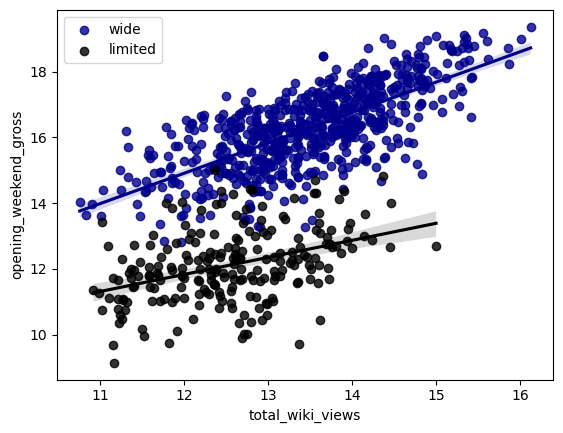

In [826]:
x = 'view_count_cume'


df_s = max_views_gross[[x,'theaters','gross']].apply(lambda d: np.log(d))
df_s.loc[np.exp(df_s.theaters) > 600, 'wide'] ='wide'

# df_s = df_s.loc[np.exp(df_s.locs_1_max) < 1000]

df_s['wide'].fillna('limited', inplace=True )

df_s.columns = ['total_wiki_views','theaters','opening_weekend_gross','wide']


fig, ax = plt.subplots()
# plt.figure(figsize=(35,25))
colors = ['darkblue', 'black','green','orange','lightblue']

for i, value in enumerate(df_s.wide.unique()):
    ax = sns.regplot(x='total_wiki_views', y="opening_weekend_gross", ax=ax,
                     color=colors[i],
                     data=df_s[df_s.wide == value],
                     label=value, )

ax.legend(loc='best') 
display(fig)
plt.close('all')
    

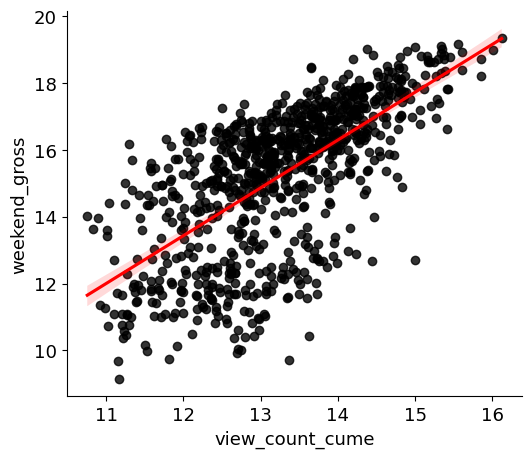

In [879]:
plt.figure(figsize = (20,5))

# for i,x in enumerate(int_features):

x = 'view_count_cume'
ax = plt.subplot(1,3,1)
sns.regplot(data=max_views_gross[[x, 'gross']].apply(lambda d: np.log(d)),x=x,y="gross",
            scatter_kws={"color": "black"}, line_kws={"color": "red"})
# ax.set_title(x+' regplot',fontsize=20)
plt.tick_params(labelsize=13)
plt.xlabel(x,fontsize=13)
plt.ylabel("weekend_gross",fontsize=13)
sns.despine()
plt.show()

### correlation

#### correlation between box office and wikipedia views

In [884]:
stats.pearsonr(max_views_gross['view_count_cume'], max_views_gross['gross'])

PearsonRResult(statistic=0.7686254657368834, pvalue=3.326327010634497e-170)

#### correlation between box office and wikipedia views by release type

In [885]:
stats.pearsonr(max_views_gross[max_views_gross['theaters'] <= 600]['view_count_cume'], 
               max_views_gross[max_views_gross['theaters'] <= 600]['gross'])

PearsonRResult(statistic=0.28187707528715594, pvalue=1.9318580645768846e-05)

In [886]:
stats.pearsonr(max_views_gross[max_views_gross['theaters'] > 600]['view_count_cume'], 
               max_views_gross[max_views_gross['theaters'] > 600]['gross'])

PearsonRResult(statistic=0.7585514922114517, pvalue=1.0295121236722824e-121)